## Setup

In [96]:
!pip install pyvene

import pyvene as pv

In [97]:
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)
import torch
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    geom_line,
    geom_point,
    geom_text,
    ggtitle, xlab, ylab,
    ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm
from collections import namedtuple

## Load model and data

In [98]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = "EleutherAI/pythia-70m" # "EleutherAI/pythia-6.9B"
tokenizer = AutoTokenizer.from_pretrained(model)
tokenizer.pad_token = tokenizer.eos_token
gpt = AutoModelForCausalLM.from_pretrained(
    model,
    revision="main",
    torch_dtype=torch.bfloat16 if model == "EleutherAI/pythia-6.9b" else torch.float32,
).to(device)

In [99]:
from datasets import load_dataset

ds = load_dataset("tasksource/babi_nli", "basic-deduction")

We have a list of 100 names for each gender, and we'll filter for names that are one token in length. We'll further filter for examples the model agrees with our labels for, since some of these names might be ambiguous or the model might not have the expected behaviour. This ensures that baseline IIA is 0.

In [100]:
def get_input_and_label(sample):
    full_sample = sample["hypothesis"] + " " + sample["premise"]
    elements = full_sample.split(" ")
    input_ = " ".join(elements[:-1]) + " "
    label = elements[-1].rstrip(".!? \n")
    return input_, label

In [101]:
SINGLE_TOKEN_ANIMALS = ['mouse', 'cat', 'wolf', 'cats']

def filter_dataset(ds):
    filtered_ds = []
    for sample in ds:
        if sample["label"] == 0:
            input_, label = get_input_and_label(sample)
            if label in SINGLE_TOKEN_ANIMALS:
                filtered_ds.append({"sample": input_, "label": label})
    return filtered_ds

In [102]:
filtered_dataset = filter_dataset(ds["train"])

In [103]:
filtered_dataset[0]["sample"]

'Emily is afraid of cat. Sheep are afraid of mice. Emily is a sheep. Cats are afraid of mice. Wolves are afraid of cats. Mice are afraid of wolves. Winona is a mouse. Gertrude is a cat. Jessica is a '

In [104]:
unique_labels = set([sample["label"] for sample in filtered_dataset])

In [105]:
unique_labels

{'cat', 'cats', 'mouse', 'wolf'}

In [106]:
for label in unique_labels:
    tokenized = tokenizer.encode(label)
    print(label)
    print(tokenized)

mouse
[19618]
cats
[38718]
cat
[8076]
wolf
[40995]


In [107]:
Example = namedtuple("Example", ["base", "src", "base_label", "src_label"])

def sample_example(tokenizer):
    base_sample = random.choice(filtered_dataset)
    src_samples = [sample for sample in filtered_dataset if sample["label"] != base_sample["label"]]

    src_sample = random.choice(src_samples)

    base = tokenizer(base_sample["sample"], return_tensors="pt")
    src = tokenizer(src_sample["sample"], return_tensors="pt")
    base_label = tokenizer.encode(base_sample["label"])[0]
    src_label = tokenizer.encode(src_sample["label"])[0]
    return Example(base, src, base_label, src_label)

In [108]:
def generate_n_doable_examples(n, model, tokenizer):
    examples = []
    iterator = tqdm(range(n))
    while len(examples) < n:
        ex = sample_example(tokenizer)
        for k, v in ex.base.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.base[k] = v.to(model.device)
        for k, v in ex.src.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.src[k] = v.to(model.device)
        logits_base = model(**ex.base).logits[0, -1]
        logits_src = model(**ex.src).logits[0, -1]
        if (
            logits_base[ex.base_label] > logits_base[ex.src_label]
            and logits_src[ex.src_label] > logits_src[ex.base_label]
        ):
            examples.append(ex)
            iterator.update(1)
    return examples

In [109]:
# make dataset
total_steps = 300
trainset = generate_n_doable_examples(total_steps, gpt, tokenizer)
evalset = generate_n_doable_examples(50, gpt, tokenizer)

print(f"Liczba przykładów w zbiorze treningowym: {len(trainset)}")
print(f"Liczba przykładów w zbiorze walidacyjnym: {len(evalset)}")
print("Przykład z trainset:", trainset[0])
print("Przykład z evalset:", evalset[0])

  0%|          | 1/300 [00:00<01:27,  3.40it/s]

Logity base: 999.5421752929688 > 998.7310791015625
Logity src: 1013.1852416992188 > 1011.7257080078125


  1%|          | 2/300 [00:02<07:02,  1.42s/it]

Logity base: 989.2550659179688 > 987.7819213867188
Logity src: 1013.1852416992188 > 1009.646240234375


  1%|          | 3/300 [00:04<09:14,  1.87s/it]

Logity base: 1022.94775390625 > 1018.8404541015625
Logity src: 984.4973754882812 > 982.9558715820312


  1%|▏         | 4/300 [00:06<08:12,  1.66s/it]

Logity base: 996.4364013671875 > 994.5621948242188
Logity src: 1022.7802734375 > 1020.85302734375


  2%|▏         | 5/300 [00:07<08:03,  1.64s/it]

Logity base: 991.6095581054688 > 990.706787109375
Logity src: 1022.94775390625 > 1018.8404541015625


  2%|▏         | 7/300 [00:08<04:08,  1.18it/s]

Logity base: 1017.9042358398438 > 1014.9337768554688
Logity src: 992.1718139648438 > 989.9271850585938
Logity base: 1024.05322265625 > 1019.7213745117188
Logity src: 990.0888671875 > 988.0616455078125


  3%|▎         | 8/300 [00:08<03:05,  1.58it/s]

Logity base: 999.2941284179688 > 996.4572143554688
Logity src: 1013.1852416992188 > 1011.7257080078125


  3%|▎         | 10/300 [00:09<02:39,  1.82it/s]

Logity base: 991.6095581054688 > 990.706787109375
Logity src: 1020.4594116210938 > 1017.3597412109375
Logity base: 995.0307006835938 > 992.5098876953125
Logity src: 1014.2542114257812 > 1011.966796875


  4%|▍         | 12/300 [00:10<02:02,  2.36it/s]

Logity base: 999.3012084960938 > 997.5631713867188
Logity src: 1019.7442016601562 > 1016.7965698242188
Logity base: 989.8936767578125 > 987.7422485351562
Logity src: 1013.4755859375 > 1013.2503051757812


  4%|▍         | 13/300 [00:12<04:35,  1.04it/s]

Logity base: 1013.4755859375 > 1013.2503051757812
Logity src: 997.6350708007812 > 996.0940551757812


  5%|▍         | 14/300 [00:15<07:57,  1.67s/it]

Logity base: 994.1483764648438 > 993.0056762695312
Logity src: 1013.1852416992188 > 1009.646240234375


  5%|▌         | 15/300 [00:17<07:43,  1.63s/it]

Logity base: 988.9683227539062 > 988.1373291015625
Logity src: 1022.7802734375 > 1018.4259033203125


  5%|▌         | 16/300 [00:20<10:11,  2.15s/it]

Logity base: 994.4651489257812 > 993.9646606445312
Logity src: 1024.9615478515625 > 1022.4404907226562


  6%|▌         | 17/300 [00:21<07:42,  1.63s/it]

Logity base: 1014.1241455078125 > 1011.660888671875
Logity src: 994.04638671875 > 991.66259765625


  6%|▌         | 18/300 [00:22<08:04,  1.72s/it]

Logity base: 1020.9100952148438 > 1020.1027221679688
Logity src: 997.3486938476562 > 995.600830078125


  6%|▋         | 19/300 [00:23<05:59,  1.28s/it]

Logity base: 1017.5205078125 > 1016.2943725585938
Logity src: 998.1660766601562 > 996.4578857421875


  7%|▋         | 21/300 [00:24<04:04,  1.14it/s]

Logity base: 1022.94775390625 > 1019.1494140625
Logity src: 992.3060913085938 > 990.1483154296875
Logity base: 1022.6452026367188 > 1021.10498046875
Logity src: 1003.8947143554688 > 1000.8735961914062


  7%|▋         | 22/300 [00:24<03:39,  1.27it/s]

Logity base: 992.538818359375 > 989.414306640625
Logity src: 1016.212158203125 > 1013.6364135742188


  8%|▊         | 23/300 [00:25<03:59,  1.16it/s]

Logity base: 989.8936767578125 > 987.7422485351562
Logity src: 1018.8194580078125 > 1017.6823120117188


  8%|▊         | 24/300 [00:26<03:59,  1.15it/s]

Logity base: 1019.7674560546875 > 1017.622802734375
Logity src: 987.5881958007812 > 986.2529907226562


  8%|▊         | 25/300 [00:27<03:48,  1.21it/s]

Logity base: 999.2941284179688 > 996.1312866210938
Logity src: 991.6095581054688 > 991.6093139648438


  9%|▊         | 26/300 [00:28<04:10,  1.09it/s]

Logity base: 1018.4136962890625 > 1015.1552734375
Logity src: 992.3060913085938 > 990.1483154296875


  9%|▉         | 27/300 [00:29<04:03,  1.12it/s]

Logity base: 996.0999145507812 > 994.3738403320312
Logity src: 1014.8529052734375 > 1013.9115600585938


  9%|▉         | 28/300 [00:30<04:05,  1.11it/s]

Logity base: 1014.1241455078125 > 1011.660888671875
Logity src: 998.4354248046875 > 998.3871459960938


 10%|█         | 30/300 [00:32<04:23,  1.02it/s]

Logity base: 999.1200561523438 > 997.1612548828125
Logity src: 1018.4136962890625 > 1015.1552734375
Logity base: 993.2481689453125 > 990.9320068359375
Logity src: 1013.0143432617188 > 1011.102294921875


 10%|█         | 31/300 [00:33<04:07,  1.09it/s]

Logity base: 1013.1852416992188 > 1011.7257080078125
Logity src: 994.8150634765625 > 993.9791259765625


 11%|█         | 32/300 [00:37<07:28,  1.67s/it]

Logity base: 1013.1852416992188 > 1011.7257080078125
Logity src: 1002.5990600585938 > 1001.0032958984375


 11%|█         | 33/300 [00:37<05:33,  1.25s/it]

Logity base: 991.6322021484375 > 990.174072265625
Logity src: 1014.315673828125 > 1012.6033325195312


 11%|█▏        | 34/300 [00:37<04:30,  1.02s/it]

Logity base: 1022.94775390625 > 1019.1494140625
Logity src: 993.65771484375 > 992.033447265625


 12%|█▏        | 35/300 [00:39<04:44,  1.07s/it]

Logity base: 994.04638671875 > 992.44189453125
Logity src: 996.0452270507812 > 992.5673828125
Logity base: 990.0888671875 > 988.0616455078125
Logity src: 1014.2542114257812 > 1011.966796875


 12%|█▏        | 37/300 [00:39<02:46,  1.58it/s]

Logity base: 994.6951904296875 > 991.5390014648438
Logity src: 1018.3605346679688 > 1016.24658203125


 13%|█▎        | 38/300 [00:41<04:10,  1.05it/s]

Logity base: 1014.8529052734375 > 1014.1299438476562
Logity src: 992.173583984375 > 990.29443359375


 13%|█▎        | 39/300 [00:41<03:50,  1.13it/s]

Logity base: 992.7185668945312 > 991.8656616210938
Logity src: 1026.9324951171875 > 1024.285888671875


 13%|█▎        | 40/300 [00:43<04:17,  1.01it/s]

Logity base: 994.7771606445312 > 992.959228515625
Logity src: 1020.4594116210938 > 1017.1018676757812


 14%|█▍        | 42/300 [00:43<02:53,  1.48it/s]

Logity base: 996.790771484375 > 996.4765014648438
Logity src: 997.4686889648438 > 995.2020874023438
Logity base: 1024.05322265625 > 1019.645751953125
Logity src: 989.3786010742188 > 987.9734497070312


 14%|█▍        | 43/300 [00:44<02:15,  1.90it/s]

Logity base: 1017.5205078125 > 1015.4452514648438
Logity src: 994.7379760742188 > 992.715576171875
Logity base: 995.0307006835938 > 992.5098876953125
Logity src: 1014.1241455078125 > 1011.4937744140625


 15%|█▌        | 45/300 [00:45<02:39,  1.60it/s]

Logity base: 1016.8257446289062 > 1016.0077514648438
Logity src: 999.3775634765625 > 997.32763671875


 15%|█▌        | 46/300 [00:46<02:24,  1.76it/s]

Logity base: 1020.3734741210938 > 1017.16015625
Logity src: 992.3221435546875 > 990.4005126953125


 16%|█▌        | 47/300 [00:46<02:22,  1.78it/s]

Logity base: 1026.7972412109375 > 1024.177490234375
Logity src: 998.4354248046875 > 998.3871459960938


 16%|█▌        | 48/300 [00:46<02:06,  2.00it/s]

Logity base: 1016.212158203125 > 1013.6364135742188
Logity src: 995.4420166015625 > 992.8561401367188


 16%|█▋        | 49/300 [00:47<01:50,  2.26it/s]

Logity base: 1026.9324951171875 > 1024.5089111328125
Logity src: 991.0540771484375 > 989.3323364257812


 17%|█▋        | 50/300 [00:49<03:47,  1.10it/s]

Logity base: 1014.315673828125 > 1012.6033325195312
Logity src: 992.2106323242188 > 990.6903076171875


 17%|█▋        | 52/300 [00:51<03:35,  1.15it/s]

Logity base: 990.5304565429688 > 989.0339965820312
Logity src: 1018.9240112304688 > 1016.80078125
Logity base: 1017.5205078125 > 1015.4452514648438
Logity src: 980.04248046875 > 979.5619506835938


 18%|█▊        | 53/300 [00:51<02:55,  1.41it/s]

Logity base: 998.8458251953125 > 996.5679321289062
Logity src: 1022.7802734375 > 1020.85302734375


 18%|█▊        | 54/300 [00:51<02:25,  1.69it/s]

Logity base: 995.6763916015625 > 993.5961303710938
Logity src: 1022.6452026367188 > 1018.4671020507812


 18%|█▊        | 55/300 [00:52<02:34,  1.59it/s]

Logity base: 1014.1241455078125 > 1011.4937744140625
Logity src: 995.0307006835938 > 992.5098876953125
Logity base: 985.4822387695312 > 983.8336791992188
Logity src: 998.7296752929688 > 997.4608154296875


 19%|█▉        | 57/300 [00:53<01:52,  2.15it/s]

Logity base: 985.4822387695312 > 983.8336791992188
Logity src: 993.4675903320312 > 990.5023803710938
Logity base: 1020.3734741210938 > 1018.1458129882812
Logity src: 989.8936767578125 > 987.7422485351562


 20%|█▉        | 59/300 [00:53<01:47,  2.24it/s]

Logity base: 1017.9042358398438 > 1014.9337768554688
Logity src: 995.5111083984375 > 993.2625732421875


 20%|██        | 60/300 [00:54<01:37,  2.46it/s]

Logity base: 1024.05322265625 > 1019.645751953125
Logity src: 995.2047119140625 > 994.6654663085938


 20%|██        | 61/300 [00:54<01:36,  2.47it/s]

Logity base: 994.3130493164062 > 993.4451293945312
Logity src: 1024.9615478515625 > 1022.4404907226562


 21%|██        | 62/300 [00:55<02:09,  1.84it/s]

Logity base: 1014.2542114257812 > 1011.966796875
Logity src: 989.8936767578125 > 987.7422485351562
Logity base: 1017.9042358398438 > 1014.9337768554688
Logity src: 990.0888671875 > 988.0616455078125


 21%|██▏       | 64/300 [00:55<01:27,  2.70it/s]

Logity base: 990.8020629882812 > 989.1990356445312
Logity src: 1013.4755859375 > 1013.2503051757812
Logity base: 990.4263916015625 > 987.8300170898438
Logity src: 1016.8257446289062 > 1014.9523315429688


 22%|██▏       | 66/300 [00:56<01:05,  3.55it/s]

Logity base: 1020.3734741210938 > 1017.16015625
Logity src: 1000.5067749023438 > 999.916015625


 22%|██▏       | 67/300 [00:56<01:17,  3.01it/s]

Logity base: 989.68359375 > 987.0794677734375
Logity src: 1024.9615478515625 > 1022.816162109375


 23%|██▎       | 68/300 [00:56<01:10,  3.30it/s]

Logity base: 1015.57763671875 > 1012.854248046875
Logity src: 989.3786010742188 > 987.9734497070312


 23%|██▎       | 69/300 [00:57<01:15,  3.08it/s]

Logity base: 991.507568359375 > 988.611083984375
Logity src: 1018.4136962890625 > 1016.5062866210938


 23%|██▎       | 70/300 [00:58<01:43,  2.23it/s]

Logity base: 1022.94775390625 > 1018.8404541015625
Logity src: 990.380615234375 > 990.052001953125


 24%|██▎       | 71/300 [00:58<01:30,  2.54it/s]

Logity base: 995.2047119140625 > 994.6654663085938
Logity src: 1024.9615478515625 > 1022.4404907226562


 24%|██▍       | 72/300 [00:59<02:30,  1.52it/s]

Logity base: 1017.2550048828125 > 1015.628662109375
Logity src: 995.0701293945312 > 992.4371337890625


 24%|██▍       | 73/300 [01:00<02:29,  1.52it/s]

Logity base: 994.0161743164062 > 993.1709594726562
Logity src: 1024.05322265625 > 1019.645751953125
Logity base: 992.3221435546875 > 991.6712036132812

 25%|██▍       | 74/300 [01:00<01:59,  1.90it/s]


Logity src: 999.067138671875 > 997.7019653320312


 25%|██▌       | 75/300 [01:01<02:07,  1.76it/s]

Logity base: 1022.6452026367188 > 1018.4671020507812
Logity src: 989.3870239257812 > 988.3523559570312


 25%|██▌       | 76/300 [01:02<02:50,  1.31it/s]

Logity base: 1018.3605346679688 > 1015.3385620117188
Logity src: 992.1718139648438 > 989.9271850585938


 26%|██▌       | 77/300 [01:07<07:52,  2.12s/it]

Logity base: 992.7185668945312 > 991.8656616210938
Logity src: 1026.7972412109375 > 1024.177490234375


 26%|██▌       | 78/300 [01:08<06:00,  1.62s/it]

Logity base: 1000.74169921875 > 999.2489624023438
Logity src: 1022.7802734375 > 1018.4259033203125


 26%|██▋       | 79/300 [01:09<05:53,  1.60s/it]

Logity base: 997.7188110351562 > 996.049072265625
Logity src: 1026.7972412109375 > 1024.177490234375


 27%|██▋       | 80/300 [01:10<04:29,  1.23s/it]

Logity base: 1013.0143432617188 > 1011.102294921875
Logity src: 998.2037963867188 > 995.7500610351562


 27%|██▋       | 81/300 [01:10<03:30,  1.04it/s]

Logity base: 1000.1193237304688 > 998.4793701171875
Logity src: 1022.94775390625 > 1019.1494140625


 27%|██▋       | 82/300 [01:11<03:09,  1.15it/s]

Logity base: 1003.4125366210938 > 1000.5518188476562
Logity src: 1022.7802734375 > 1020.85302734375


 28%|██▊       | 83/300 [01:12<03:58,  1.10s/it]

Logity base: 994.8150634765625 > 993.9791259765625
Logity src: 1014.1241455078125 > 1011.4937744140625


 28%|██▊       | 84/300 [01:12<03:04,  1.17it/s]

Logity base: 1024.9615478515625 > 1022.4404907226562
Logity src: 996.8046264648438 > 996.1466674804688


 28%|██▊       | 85/300 [01:13<02:38,  1.35it/s]

Logity base: 993.7921142578125 > 991.4013061523438
Logity src: 1013.0143432617188 > 1011.102294921875


 29%|██▊       | 86/300 [01:15<04:25,  1.24s/it]

Logity base: 998.3049926757812 > 997.3489379882812
Logity src: 1013.5130004882812 > 1013.296142578125


 29%|██▉       | 87/300 [01:16<03:20,  1.06it/s]

Logity base: 1001.44970703125 > 1001.360595703125
Logity src: 1019.7442016601562 > 1017.3837890625


 29%|██▉       | 88/300 [01:16<02:44,  1.29it/s]

Logity base: 1014.315673828125 > 1012.6033325195312
Logity src: 991.6322021484375 > 990.174072265625


 30%|███       | 90/300 [01:17<01:55,  1.82it/s]

Logity base: 1000.74169921875 > 999.2489624023438
Logity src: 1016.212158203125 > 1012.273681640625
Logity base: 1017.2550048828125 > 1014.6688842773438
Logity src: 994.7235107421875 > 993.8556518554688


 31%|███       | 92/300 [01:18<01:47,  1.94it/s]

Logity base: 999.3012084960938 > 996.9212646484375
Logity src: 985.4822387695312 > 983.8336791992188
Logity base: 999.3775634765625 > 997.32763671875
Logity src: 1024.05322265625 > 1019.7213745117188


 31%|███       | 93/300 [01:18<01:25,  2.41it/s]

Logity base: 988.9683227539062 > 988.1373291015625
Logity src: 1019.7442016601562 > 1017.3837890625


 32%|███▏      | 95/300 [01:19<01:26,  2.37it/s]

Logity base: 994.04638671875 > 992.44189453125
Logity src: 994.5855712890625 > 993.0496215820312
Logity base: 995.0098876953125 > 994.8683471679688
Logity src: 1017.9042358398438 > 1016.7673950195312


 32%|███▏      | 96/300 [01:21<02:57,  1.15it/s]

Logity base: 994.5250854492188 > 992.6436157226562
Logity src: 990.5304565429688 > 990.0460205078125


 33%|███▎      | 98/300 [01:22<02:19,  1.45it/s]

Logity base: 994.251708984375 > 993.8057861328125
Logity src: 1014.315673828125 > 1011.9801025390625
Logity base: 998.3049926757812 > 997.5547485351562
Logity src: 992.4462280273438 > 991.7112426757812


 33%|███▎      | 99/300 [01:23<02:17,  1.46it/s]

Logity base: 1018.9240112304688 > 1015.7969970703125
Logity src: 1003.8947143554688 > 1000.8735961914062


 33%|███▎      | 100/300 [01:23<02:01,  1.65it/s]

Logity base: 998.8458251953125 > 996.5679321289062
Logity src: 1026.9324951171875 > 1024.5089111328125


 34%|███▎      | 101/300 [01:24<01:53,  1.75it/s]

Logity base: 998.1660766601562 > 995.9445190429688
Logity src: 991.6095581054688 > 991.6093139648438


 34%|███▍      | 102/300 [01:24<01:39,  1.99it/s]

Logity base: 990.5304565429688 > 990.0460205078125
Logity src: 995.0307006835938 > 992.6363525390625


 34%|███▍      | 103/300 [01:25<01:42,  1.92it/s]

Logity base: 1024.9615478515625 > 1022.816162109375
Logity src: 997.8886108398438 > 995.572265625


 35%|███▍      | 104/300 [01:25<01:32,  2.12it/s]

Logity base: 1000.5128173828125 > 998.375244140625
Logity src: 1014.315673828125 > 1012.6033325195312


 35%|███▌      | 105/300 [01:26<02:26,  1.33it/s]

Logity base: 991.0540771484375 > 989.3323364257812
Logity src: 1024.05322265625 > 1019.7213745117188


 35%|███▌      | 106/300 [01:27<02:25,  1.33it/s]

Logity base: 994.5250854492188 > 993.3958740234375
Logity src: 1017.5205078125 > 1016.2943725585938


 36%|███▌      | 107/300 [01:27<01:59,  1.61it/s]

Logity base: 996.2175903320312 > 995.0947265625
Logity src: 992.3221435546875 > 991.6712036132812


 36%|███▌      | 108/300 [01:28<01:47,  1.78it/s]

Logity base: 1019.7442016601562 > 1016.7965698242188
Logity src: 993.7921142578125 > 991.4013061523438
Logity base: 1014.315673828125 > 1011.9801025390625
Logity src: 991.6529541015625 > 990.8372802734375


 37%|███▋      | 110/300 [01:28<01:09,  2.73it/s]

Logity base: 985.4822387695312 > 982.296630859375
Logity src: 1015.57763671875 > 1012.854248046875


 37%|███▋      | 111/300 [01:28<01:04,  2.93it/s]

Logity base: 1014.2542114257812 > 1011.966796875
Logity src: 999.132568359375 > 997.3340454101562


 37%|███▋      | 112/300 [01:29<01:03,  2.94it/s]

Logity base: 995.7236938476562 > 993.8457641601562
Logity src: 1019.7674560546875 > 1018.286376953125


 38%|███▊      | 113/300 [01:29<01:07,  2.75it/s]

Logity base: 1026.7972412109375 > 1024.177490234375
Logity src: 994.8346557617188 > 993.1760864257812


 38%|███▊      | 114/300 [01:31<02:35,  1.20it/s]

Logity base: 1013.0143432617188 > 1011.8302001953125
Logity src: 995.0098876953125 > 994.8683471679688


 38%|███▊      | 115/300 [01:32<02:15,  1.36it/s]

Logity base: 996.0999145507812 > 993.8446655273438
Logity src: 995.6763916015625 > 995.4525146484375


 39%|███▉      | 117/300 [01:32<01:25,  2.13it/s]

Logity base: 993.9576416015625 > 993.484619140625
Logity src: 1022.6452026367188 > 1018.4671020507812
Logity base: 992.4092407226562 > 991.5108642578125
Logity src: 991.507568359375 > 990.0062866210938


 39%|███▉      | 118/300 [01:33<01:31,  1.99it/s]

Logity base: 1014.8529052734375 > 1013.9115600585938
Logity src: 1000.5128173828125 > 998.375244140625


 40%|███▉      | 119/300 [01:33<01:20,  2.26it/s]

Logity base: 1014.315673828125 > 1011.9801025390625
Logity src: 997.790283203125 > 997.287353515625


 40%|████      | 120/300 [01:36<03:24,  1.13s/it]

Logity base: 1022.94775390625 > 1018.8404541015625
Logity src: 998.3248901367188 > 997.07177734375


 40%|████      | 121/300 [01:37<03:14,  1.09s/it]

Logity base: 994.6951904296875 > 991.5390014648438
Logity src: 1013.4755859375 > 1010.9195556640625


 41%|████      | 122/300 [01:37<02:50,  1.04it/s]

Logity base: 1001.6962280273438 > 998.229736328125
Logity src: 1013.5130004882812 > 1013.296142578125


 41%|████      | 123/300 [01:38<02:27,  1.20it/s]

Logity base: 992.6488037109375 > 991.0370483398438
Logity src: 1020.9100952148438 > 1018.841064453125


 41%|████▏     | 124/300 [01:39<02:23,  1.23it/s]

Logity base: 1022.3386840820312 > 1019.328857421875
Logity src: 989.2550659179688 > 987.7819213867188


 42%|████▏     | 125/300 [01:40<02:41,  1.08it/s]

Logity base: 994.5250854492188 > 992.6436157226562
Logity src: 995.6763916015625 > 995.4525146484375


 42%|████▏     | 126/300 [01:41<02:35,  1.12it/s]

Logity base: 995.7236938476562 > 993.8457641601562
Logity src: 1024.9615478515625 > 1022.816162109375


 42%|████▏     | 127/300 [01:41<02:11,  1.32it/s]

Logity base: 998.2037963867188 > 996.7232666015625
Logity src: 995.6763916015625 > 995.4525146484375


 43%|████▎     | 128/300 [01:42<02:41,  1.07it/s]

Logity base: 993.6726684570312 > 993.0464477539062
Logity src: 1022.7802734375 > 1018.4259033203125


 43%|████▎     | 129/300 [01:43<02:25,  1.17it/s]

Logity base: 1013.0143432617188 > 1011.102294921875
Logity src: 994.5250854492188 > 993.3958740234375


 44%|████▎     | 131/300 [01:43<01:25,  1.99it/s]

Logity base: 993.23388671875 > 991.1121215820312
Logity src: 1022.6452026367188 > 1021.10498046875
Logity base: 992.8368530273438 > 992.6438598632812
Logity src: 1017.2550048828125 > 1014.6688842773438


 44%|████▍     | 133/300 [01:44<01:10,  2.38it/s]

Logity base: 995.2937622070312 > 992.5383911132812
Logity src: 1014.1241455078125 > 1011.4937744140625
Logity base: 994.7235107421875 > 993.8556518554688
Logity src: 1013.0143432617188 > 1011.8302001953125


 45%|████▍     | 134/300 [01:45<01:05,  2.52it/s]

Logity base: 1023.1165771484375 > 1020.2810668945312
Logity src: 994.5250854492188 > 993.3958740234375


 45%|████▌     | 135/300 [01:45<01:25,  1.94it/s]

Logity base: 998.3049926757812 > 997.3489379882812
Logity src: 1026.9324951171875 > 1024.5089111328125


 46%|████▌     | 137/300 [01:47<01:53,  1.44it/s]

Logity base: 999.3775634765625 > 997.32763671875
Logity src: 1019.7674560546875 > 1018.286376953125
Logity base: 1013.5130004882812 > 1013.296142578125
Logity src: 995.5780639648438 > 993.5585327148438


 46%|████▌     | 138/300 [01:48<01:44,  1.55it/s]

Logity base: 993.5157470703125 > 990.830810546875
Logity src: 995.6763916015625 > 995.4525146484375


 46%|████▋     | 139/300 [01:49<01:44,  1.54it/s]

Logity base: 993.4675903320312 > 990.5023803710938
Logity src: 985.4822387695312 > 983.8336791992188


 47%|████▋     | 140/300 [01:49<01:53,  1.42it/s]

Logity base: 996.1785888671875 > 995.18212890625
Logity src: 1017.2550048828125 > 1015.628662109375


 47%|████▋     | 142/300 [01:51<01:42,  1.54it/s]

Logity base: 992.8368530273438 > 992.6438598632812
Logity src: 1013.1852416992188 > 1009.646240234375
Logity base: 997.7177124023438 > 996.2863159179688
Logity src: 1022.7802734375 > 1018.4259033203125


 48%|████▊     | 143/300 [01:51<01:27,  1.80it/s]

Logity base: 992.3060913085938 > 990.1483154296875
Logity src: 1014.315673828125 > 1012.6033325195312


 48%|████▊     | 145/300 [01:52<00:56,  2.72it/s]

Logity base: 1017.9042358398438 > 1016.7673950195312
Logity src: 984.4973754882812 > 982.9558715820312
Logity base: 1014.315673828125 > 1012.6033325195312
Logity src: 993.4675903320312 > 990.2197875976562


 49%|████▊     | 146/300 [01:53<01:21,  1.88it/s]

Logity base: 1004.6865844726562 > 1002.18408203125
Logity src: 992.4462280273438 > 991.7112426757812


 49%|████▉     | 147/300 [01:53<01:23,  1.84it/s]

Logity base: 1001.44970703125 > 1001.360595703125
Logity src: 1020.3734741210938 > 1017.16015625


 49%|████▉     | 148/300 [01:54<01:30,  1.68it/s]

Logity base: 994.5855712890625 > 993.0496215820312
Logity src: 991.6095581054688 > 991.6093139648438


 50%|████▉     | 149/300 [01:55<01:55,  1.31it/s]

Logity base: 996.2175903320312 > 995.0947265625
Logity src: 991.507568359375 > 990.0062866210938


 50%|█████     | 150/300 [01:55<01:37,  1.55it/s]

Logity base: 984.4973754882812 > 982.9558715820312
Logity src: 1017.5205078125 > 1015.4452514648438


 50%|█████     | 151/300 [01:56<01:40,  1.48it/s]

Logity base: 1014.8529052734375 > 1014.1299438476562
Logity src: 992.8368530273438 > 992.6438598632812


 51%|█████     | 153/300 [01:58<01:35,  1.55it/s]

Logity base: 1016.8257446289062 > 1016.0077514648438
Logity src: 1000.1193237304688 > 998.4793701171875
Logity base: 995.2047119140625 > 994.6654663085938
Logity src: 1014.2542114257812 > 1012.7467651367188
Logity base: 992.8368530273438 > 992.6438598632812
Logity src: 1013.4755859375 > 1010.9195556640625


 52%|█████▏    | 155/300 [01:58<01:06,  2.19it/s]

Logity base: 990.5304565429688 > 990.0460205078125
Logity src: 992.4092407226562 > 991.5108642578125


 52%|█████▏    | 156/300 [01:58<01:02,  2.31it/s]

Logity base: 1014.1241455078125 > 1011.4937744140625
Logity src: 992.2106323242188 > 990.6903076171875


 53%|█████▎    | 158/300 [01:59<00:52,  2.69it/s]

Logity base: 1019.7442016601562 > 1017.3837890625
Logity src: 990.5304565429688 > 989.0339965820312
Logity base: 996.1785888671875 > 995.18212890625
Logity src: 1022.6452026367188 > 1021.10498046875


 53%|█████▎    | 159/300 [01:59<00:49,  2.85it/s]

Logity base: 1014.8529052734375 > 1013.9115600585938
Logity src: 997.8886108398438 > 995.572265625
Logity base: 995.5111083984375 > 993.2625732421875
Logity src: 1014.1241455078125 > 1011.4937744140625


 54%|█████▍    | 162/300 [02:00<00:42,  3.28it/s]

Logity base: 1022.94775390625 > 1018.8404541015625
Logity src: 1001.44970703125 > 1001.360595703125
Logity base: 1018.8194580078125 > 1017.6823120117188
Logity src: 992.4092407226562 > 990.9321899414062


 54%|█████▍    | 163/300 [02:00<00:37,  3.61it/s]

Logity base: 1003.8947143554688 > 1000.8735961914062
Logity src: 1020.4594116210938 > 1017.1018676757812


 55%|█████▍    | 164/300 [02:02<01:13,  1.86it/s]

Logity base: 1013.0143432617188 > 1011.102294921875
Logity src: 994.5250854492188 > 993.3958740234375


 55%|█████▌    | 165/300 [02:02<01:01,  2.18it/s]

Logity base: 1020.9100952148438 > 1018.841064453125
Logity src: 989.3870239257812 > 988.3523559570312


 55%|█████▌    | 166/300 [02:02<01:03,  2.10it/s]

Logity base: 999.3012084960938 > 996.9212646484375
Logity src: 992.3221435546875 > 991.6712036132812


 56%|█████▌    | 167/300 [02:03<01:08,  1.94it/s]

Logity base: 995.3543090820312 > 992.8607788085938
Logity src: 989.3870239257812 > 989.3786010742188


 56%|█████▌    | 168/300 [02:03<01:04,  2.04it/s]

Logity base: 994.0020141601562 > 992.9418334960938
Logity src: 1020.6539306640625 > 1017.7688598632812


 56%|█████▋    | 169/300 [02:04<00:54,  2.41it/s]

Logity base: 1022.94775390625 > 1019.1494140625
Logity src: 999.5421752929688 > 998.7310791015625


 57%|█████▋    | 170/300 [02:04<00:46,  2.82it/s]

Logity base: 1014.2542114257812 > 1012.7467651367188
Logity src: 991.6095581054688 > 990.706787109375


 57%|█████▋    | 171/300 [02:04<00:43,  2.97it/s]

Logity base: 1022.3386840820312 > 1020.4740600585938
Logity src: 991.024658203125 > 988.9816284179688


 57%|█████▋    | 172/300 [02:05<00:59,  2.15it/s]

Logity base: 1023.1165771484375 > 1020.2810668945312
Logity src: 994.2977294921875 > 993.050048828125


 58%|█████▊    | 173/300 [02:05<00:57,  2.20it/s]

Logity base: 993.2481689453125 > 991.405517578125
Logity src: 991.6095581054688 > 991.6093139648438


 58%|█████▊    | 174/300 [02:08<02:17,  1.09s/it]

Logity base: 1014.8529052734375 > 1013.9115600585938
Logity src: 1002.1830444335938 > 1001.3656005859375


 58%|█████▊    | 175/300 [02:08<01:43,  1.21it/s]

Logity base: 990.5304565429688 > 990.0460205078125
Logity src: 992.3060913085938 > 989.8509521484375


 59%|█████▊    | 176/300 [02:09<01:41,  1.23it/s]

Logity base: 992.3060913085938 > 990.1483154296875
Logity src: 1021.7720947265625 > 1020.35986328125


 59%|█████▉    | 178/300 [02:11<01:32,  1.31it/s]

Logity base: 1014.8529052734375 > 1013.9115600585938
Logity src: 996.2175903320312 > 995.37060546875
Logity base: 985.4822387695312 > 983.8336791992188
Logity src: 999.3012084960938 > 996.9212646484375


 60%|██████    | 180/300 [02:11<00:53,  2.25it/s]

Logity base: 992.6488037109375 > 991.9242553710938
Logity src: 1004.6865844726562 > 1002.18408203125
Logity base: 992.173583984375 > 990.29443359375
Logity src: 1020.3734741210938 > 1017.16015625


 60%|██████    | 181/300 [02:11<01:00,  1.95it/s]

Logity base: 1001.6962280273438 > 998.229736328125
Logity src: 1023.1165771484375 > 1020.2810668945312


 61%|██████    | 183/300 [02:13<00:59,  1.97it/s]

Logity base: 989.3870239257812 > 989.3786010742188
Logity src: 993.5157470703125 > 990.830810546875
Logity base: 1022.3386840820312 > 1019.328857421875
Logity src: 993.9576416015625 > 993.484619140625


 61%|██████▏   | 184/300 [02:13<00:53,  2.17it/s]

Logity base: 990.5304565429688 > 990.0460205078125
Logity src: 992.4092407226562 > 991.5108642578125


 62%|██████▏   | 185/300 [02:13<00:45,  2.54it/s]

Logity base: 1017.9042358398438 > 1014.9337768554688
Logity src: 1001.9838256835938 > 1000.2086181640625


 62%|██████▏   | 186/300 [02:14<00:52,  2.15it/s]

Logity base: 1001.3207397460938 > 1000.1029663085938
Logity src: 1013.4755859375 > 1013.2503051757812


 62%|██████▏   | 187/300 [02:14<00:54,  2.09it/s]

Logity base: 1022.94775390625 > 1019.1494140625
Logity src: 995.7236938476562 > 993.8457641601562


 63%|██████▎   | 188/300 [02:16<01:33,  1.20it/s]

Logity base: 1017.5205078125 > 1015.4452514648438
Logity src: 1000.8885498046875 > 1000.6354370117188


 63%|██████▎   | 189/300 [02:17<01:22,  1.34it/s]

Logity base: 1013.0143432617188 > 1011.102294921875
Logity src: 999.5421752929688 > 998.7310791015625


 63%|██████▎   | 190/300 [02:17<01:12,  1.51it/s]

Logity base: 990.4263916015625 > 988.9404296875
Logity src: 1001.3207397460938 > 1001.1719360351562


 64%|██████▎   | 191/300 [02:17<00:59,  1.82it/s]

Logity base: 995.0307006835938 > 992.5098876953125
Logity src: 1021.7720947265625 > 1020.35986328125


 64%|██████▍   | 192/300 [02:18<01:01,  1.76it/s]

Logity base: 993.7921142578125 > 993.7466430664062
Logity src: 991.6095581054688 > 991.6093139648438
Logity base: 1019.7674560546875 > 1018.286376953125
Logity src: 998.2037963867188 > 995.7500610351562


 65%|██████▌   | 195/300 [02:19<00:45,  2.32it/s]

Logity base: 1020.3734741210938 > 1018.1458129882812
Logity src: 997.8886108398438 > 995.572265625
Logity base: 1019.7674560546875 > 1018.286376953125
Logity src: 996.2175903320312 > 995.37060546875
Logity base: 993.5157470703125 > 990.3277587890625
Logity src: 1020.4594116210938 > 1017.1018676757812


 66%|██████▋   | 199/300 [02:19<00:20,  4.84it/s]

Logity base: 999.5421752929688 > 998.015625
Logity src: 992.6488037109375 > 991.9242553710938
Logity base: 992.1718139648438 > 989.9271850585938
Logity src: 1022.7802734375 > 1020.85302734375
Logity base: 1013.0143432617188 > 1011.102294921875
Logity src: 1001.9838256835938 > 1000.2086181640625


 67%|██████▋   | 200/300 [02:20<00:22,  4.39it/s]

Logity base: 995.5111083984375 > 993.2625732421875
Logity src: 1018.8194580078125 > 1017.6823120117188


 67%|██████▋   | 202/300 [02:22<00:45,  2.14it/s]

Logity base: 991.6095581054688 > 990.706787109375
Logity src: 1022.94775390625 > 1018.8404541015625
Logity base: 993.2481689453125 > 991.405517578125
Logity src: 989.3870239257812 > 989.3786010742188


 68%|██████▊   | 203/300 [02:22<00:38,  2.55it/s]

Logity base: 989.5328979492188 > 987.5771484375
Logity src: 1017.5205078125 > 1015.4452514648438


 68%|██████▊   | 205/300 [02:22<00:31,  3.05it/s]

Logity base: 995.1281127929688 > 994.400146484375
Logity src: 1019.7442016601562 > 1016.7965698242188
Logity base: 990.5304565429688 > 990.0460205078125
Logity src: 994.8150634765625 > 994.6751098632812


 69%|██████▊   | 206/300 [02:25<01:25,  1.09it/s]

Logity base: 988.4749145507812 > 987.0253295898438
Logity src: 1013.0143432617188 > 1011.8302001953125


 69%|██████▉   | 207/300 [02:25<01:09,  1.35it/s]

Logity base: 1018.9240112304688 > 1016.80078125
Logity src: 993.9576416015625 > 993.484619140625


 70%|██████▉   | 209/300 [02:27<01:07,  1.34it/s]

Logity base: 1000.1193237304688 > 999.1232299804688
Logity src: 985.4822387695312 > 983.8336791992188
Logity base: 1001.9769287109375 > 1001.6702880859375
Logity src: 1020.4594116210938 > 1017.3597412109375


 70%|███████   | 210/300 [02:27<00:50,  1.78it/s]

Logity base: 1016.212158203125 > 1012.273681640625
Logity src: 992.3221435546875 > 990.4005126953125


 71%|███████   | 212/300 [02:28<00:40,  2.16it/s]

Logity base: 985.4822387695312 > 982.296630859375
Logity src: 1024.9615478515625 > 1022.4404907226562
Logity base: 999.3012084960938 > 997.5631713867188
Logity src: 1013.1852416992188 > 1011.7257080078125
Logity base: 1017.5205078125 > 1015.4452514648438
Logity src: 985.4822387695312 > 982.296630859375


 72%|███████▏  | 215/300 [02:28<00:28,  3.01it/s]

Logity base: 992.4462280273438 > 990.2994995117188
Logity src: 1014.1241455078125 > 1011.660888671875
Logity base: 994.7771606445312 > 992.959228515625
Logity src: 1022.94775390625 > 1019.1494140625


 72%|███████▏  | 216/300 [02:29<00:30,  2.73it/s]

Logity base: 997.3486938476562 > 995.600830078125
Logity src: 1020.9100952148438 > 1020.1027221679688
Logity base: 991.024658203125 > 988.9816284179688
Logity src: 1019.7442016601562 > 1016.7965698242188


 73%|███████▎  | 218/300 [02:30<00:30,  2.67it/s]

Logity base: 1018.4136962890625 > 1015.1552734375
Logity src: 998.7296752929688 > 997.9309692382812


 73%|███████▎  | 220/300 [02:30<00:25,  3.15it/s]

Logity base: 1016.8257446289062 > 1014.9523315429688
Logity src: 990.4263916015625 > 987.8300170898438
Logity base: 994.2977294921875 > 993.9105224609375
Logity src: 991.6095581054688 > 991.6093139648438


 74%|███████▎  | 221/300 [02:30<00:22,  3.59it/s]

Logity base: 1002.3903198242188 > 998.7307739257812
Logity src: 996.790771484375 > 996.4765014648438


 74%|███████▍  | 222/300 [02:32<00:40,  1.93it/s]

Logity base: 998.4354248046875 > 998.3871459960938
Logity src: 1016.212158203125 > 1012.273681640625


 74%|███████▍  | 223/300 [02:32<00:39,  1.94it/s]

Logity base: 995.0307006835938 > 992.5098876953125
Logity src: 1013.1852416992188 > 1011.7257080078125
Logity base: 989.2550659179688 > 987.7819213867188
Logity src: 1022.3386840820312 > 1019.328857421875


 75%|███████▌  | 225/300 [02:32<00:28,  2.67it/s]

Logity base: 991.6322021484375 > 990.174072265625
Logity src: 1016.8257446289062 > 1016.0077514648438


 75%|███████▌  | 226/300 [02:33<00:36,  2.01it/s]

Logity base: 995.0701293945312 > 992.4371337890625
Logity src: 1026.9324951171875 > 1024.5089111328125


 76%|███████▌  | 227/300 [02:34<00:42,  1.70it/s]

Logity base: 1014.1241455078125 > 1011.4937744140625
Logity src: 998.8458251953125 > 996.5679321289062


 76%|███████▌  | 228/300 [02:35<00:39,  1.83it/s]

Logity base: 994.1483764648438 > 993.0056762695312
Logity src: 1013.0143432617188 > 1011.8302001953125


 76%|███████▋  | 229/300 [02:35<00:41,  1.72it/s]

Logity base: 992.4092407226562 > 990.9321899414062
Logity src: 1024.05322265625 > 1019.7213745117188


 77%|███████▋  | 230/300 [02:35<00:33,  2.07it/s]

Logity base: 1002.3903198242188 > 998.7307739257812
Logity src: 996.790771484375 > 996.4765014648438


 78%|███████▊  | 233/300 [02:36<00:17,  3.75it/s]

Logity base: 1026.7972412109375 > 1024.177490234375
Logity src: 989.3870239257812 > 988.3523559570312
Logity base: 994.2977294921875 > 993.050048828125
Logity src: 1013.1852416992188 > 1011.7257080078125
Logity base: 998.3049926757812 > 997.5547485351562
Logity src: 991.507568359375 > 990.0062866210938


 78%|███████▊  | 234/300 [02:37<00:26,  2.45it/s]

Logity base: 1022.7802734375 > 1020.85302734375
Logity src: 993.5157470703125 > 990.3277587890625


 78%|███████▊  | 235/300 [02:37<00:27,  2.39it/s]

Logity base: 995.2047119140625 > 994.7373657226562
Logity src: 995.4420166015625 > 993.1013793945312


 79%|███████▉  | 237/300 [02:38<00:28,  2.21it/s]

Logity base: 992.8368530273438 > 992.6438598632812
Logity src: 1018.9240112304688 > 1016.80078125
Logity base: 991.507568359375 > 990.0062866210938
Logity src: 998.6001586914062 > 998.5236206054688


 79%|███████▉  | 238/300 [02:39<00:27,  2.27it/s]

Logity base: 999.5421752929688 > 998.015625
Logity src: 985.4822387695312 > 983.8336791992188


 80%|███████▉  | 239/300 [02:40<00:36,  1.69it/s]

Logity base: 995.2937622070312 > 992.5383911132812
Logity src: 1014.8529052734375 > 1013.9115600585938


 80%|████████  | 241/300 [02:42<00:47,  1.25it/s]

Logity base: 1019.7674560546875 > 1018.286376953125
Logity src: 995.7236938476562 > 993.8457641601562
Logity base: 1022.94775390625 > 1018.8404541015625
Logity src: 991.6529541015625 > 990.8372802734375


 81%|████████  | 242/300 [02:43<00:48,  1.20it/s]

Logity base: 1022.7802734375 > 1020.85302734375
Logity src: 990.8020629882812 > 989.1990356445312


 81%|████████  | 243/300 [02:44<00:42,  1.33it/s]

Logity base: 1018.3605346679688 > 1016.24658203125
Logity src: 995.2047119140625 > 994.6654663085938


 81%|████████▏ | 244/300 [02:44<00:33,  1.69it/s]

Logity base: 998.2345581054688 > 995.9048461914062
Logity src: 1014.1241455078125 > 1011.4937744140625


 82%|████████▏ | 245/300 [02:44<00:28,  1.95it/s]

Logity base: 1022.94775390625 > 1019.1494140625
Logity src: 1001.6962280273438 > 998.229736328125


 82%|████████▏ | 247/300 [02:45<00:26,  2.02it/s]

Logity base: 992.3221435546875 > 991.6712036132812
Logity src: 1001.9838256835938 > 1000.9935302734375
Logity base: 1004.6865844726562 > 1002.18408203125
Logity src: 995.6763916015625 > 995.4525146484375


 83%|████████▎ | 248/300 [02:45<00:19,  2.61it/s]

Logity base: 995.0307006835938 > 992.6363525390625
Logity src: 992.6488037109375 > 991.9242553710938


 83%|████████▎ | 249/300 [02:46<00:18,  2.70it/s]

Logity base: 990.5304565429688 > 990.0460205078125
Logity src: 994.0933227539062 > 992.5541381835938


 83%|████████▎ | 250/300 [02:46<00:16,  3.02it/s]

Logity base: 1016.212158203125 > 1013.6364135742188
Logity src: 995.5111083984375 > 993.2625732421875


 84%|████████▎ | 251/300 [02:46<00:16,  2.99it/s]

Logity base: 995.5111083984375 > 993.2625732421875
Logity src: 1018.3605346679688 > 1015.3385620117188


 84%|████████▍ | 252/300 [02:46<00:14,  3.36it/s]

Logity base: 1004.6865844726562 > 1002.18408203125
Logity src: 991.6095581054688 > 991.6093139648438


 84%|████████▍ | 253/300 [02:47<00:18,  2.49it/s]

Logity base: 991.9563598632812 > 988.0537109375
Logity src: 1018.3605346679688 > 1015.3385620117188


 85%|████████▌ | 255/300 [02:48<00:16,  2.67it/s]

Logity base: 997.7534790039062 > 995.4061279296875
Logity src: 1026.9324951171875 > 1024.5089111328125
Logity base: 1018.9240112304688 > 1016.80078125
Logity src: 988.9683227539062 > 988.1373291015625
Logity base: 996.4364013671875 > 994.5621948242188
Logity src: 1020.3734741210938 > 1018.1458129882812


 86%|████████▌ | 257/300 [02:48<00:11,  3.75it/s]

Logity base: 995.0098876953125 > 994.8683471679688
Logity src: 1018.3605346679688 > 1016.24658203125


 86%|████████▋ | 259/300 [02:49<00:13,  3.13it/s]

Logity base: 994.5250854492188 > 993.3958740234375
Logity src: 1024.05322265625 > 1019.7213745117188
Logity base: 992.4462280273438 > 991.7112426757812
Logity src: 1002.3903198242188 > 998.7307739257812


 87%|████████▋ | 261/300 [02:50<00:13,  2.91it/s]

Logity base: 990.5304565429688 > 989.0339965820312
Logity src: 1016.212158203125 > 1012.273681640625
Logity base: 1017.9042358398438 > 1016.7673950195312
Logity src: 991.0189819335938 > 989.7047119140625


 87%|████████▋ | 262/300 [02:50<00:13,  2.79it/s]

Logity base: 998.4354248046875 > 998.3871459960938
Logity src: 1020.9100952148438 > 1018.841064453125


 88%|████████▊ | 263/300 [02:51<00:16,  2.23it/s]

Logity base: 991.0540771484375 > 989.3323364257812
Logity src: 1014.1241455078125 > 1011.4937744140625
Logity base: 1023.1165771484375 > 1020.2810668945312
Logity src: 1002.5990600585938 > 1001.0032958984375


 88%|████████▊ | 265/300 [02:51<00:12,  2.86it/s]

Logity base: 1013.5130004882812 > 1010.19580078125
Logity src: 992.3221435546875 > 990.4005126953125


 89%|████████▊ | 266/300 [02:52<00:12,  2.81it/s]

Logity base: 1013.5130004882812 > 1010.19580078125
Logity src: 991.6095581054688 > 990.706787109375


 89%|████████▉ | 267/300 [02:52<00:12,  2.73it/s]

Logity base: 1022.94775390625 > 1018.8404541015625
Logity src: 989.3786010742188 > 987.9734497070312


 89%|████████▉ | 268/300 [02:53<00:20,  1.57it/s]

Logity base: 995.610107421875 > 993.90576171875
Logity src: 1015.57763671875 > 1012.854248046875


 90%|████████▉ | 269/300 [02:54<00:21,  1.45it/s]

Logity base: 1023.1165771484375 > 1020.2810668945312
Logity src: 993.5157470703125 > 990.3277587890625
Logity base: 1022.7802734375 > 1020.85302734375
Logity src: 995.3543090820312 > 993.33349609375


 90%|█████████ | 271/300 [02:55<00:17,  1.64it/s]

Logity base: 995.3543090820312 > 993.33349609375
Logity src: 1024.05322265625 > 1019.7213745117188


 91%|█████████ | 272/300 [02:57<00:27,  1.02it/s]

Logity base: 1018.4136962890625 > 1015.1552734375
Logity src: 994.5250854492188 > 993.3958740234375


 91%|█████████ | 273/300 [02:58<00:23,  1.15it/s]

Logity base: 1022.94775390625 > 1019.1494140625
Logity src: 989.8936767578125 > 987.7422485351562
Logity base: 993.7921142578125 > 991.4013061523438
Logity src: 1020.3734741210938 > 1018.1458129882812


 92%|█████████▏| 276/300 [02:58<00:10,  2.37it/s]

Logity base: 995.2047119140625 > 994.7373657226562
Logity src: 994.0933227539062 > 992.5541381835938
Logity base: 992.1718139648438 > 989.9271850585938
Logity src: 1022.6452026367188 > 1021.10498046875


 93%|█████████▎| 278/300 [02:58<00:06,  3.29it/s]

Logity base: 995.6763916015625 > 993.5961303710938
Logity src: 1014.1241455078125 > 1011.660888671875
Logity base: 1024.05322265625 > 1019.645751953125
Logity src: 1000.8885498046875 > 1000.6354370117188


 93%|█████████▎| 279/300 [02:59<00:05,  4.03it/s]

Logity base: 1023.1165771484375 > 1018.251220703125
Logity src: 994.8346557617188 > 993.1760864257812
Logity base: 995.3558959960938 > 994.8767700195312
Logity src: 1020.9100952148438 > 1018.841064453125


 94%|█████████▎| 281/300 [02:59<00:03,  5.23it/s]

Logity base: 991.507568359375 > 988.611083984375
Logity src: 1014.8529052734375 > 1014.1299438476562


 94%|█████████▍| 282/300 [02:59<00:05,  3.45it/s]

Logity base: 995.3543090820312 > 993.33349609375
Logity src: 1017.5205078125 > 1016.2943725585938


 94%|█████████▍| 283/300 [03:00<00:04,  3.59it/s]

Logity base: 997.4686889648438 > 995.7117309570312
Logity src: 1023.1165771484375 > 1020.2810668945312


 95%|█████████▌| 285/300 [03:00<00:03,  4.19it/s]

Logity base: 1014.1241455078125 > 1011.660888671875
Logity src: 998.3248901367188 > 997.07177734375
Logity base: 1022.3386840820312 > 1019.328857421875
Logity src: 996.4358520507812 > 995.6198120117188


 95%|█████████▌| 286/300 [03:00<00:04,  3.47it/s]

Logity base: 1013.5130004882812 > 1010.19580078125
Logity src: 985.4822387695312 > 982.296630859375


 96%|█████████▋| 289/300 [03:01<00:02,  3.76it/s]

Logity base: 997.8886108398438 > 995.572265625
Logity src: 1013.1852416992188 > 1011.7257080078125
Logity base: 992.3060913085938 > 990.1483154296875
Logity src: 1013.1852416992188 > 1011.7257080078125
Logity base: 992.538818359375 > 990.064453125
Logity src: 995.2047119140625 > 994.7373657226562


 97%|█████████▋| 290/300 [03:02<00:02,  3.70it/s]

Logity base: 992.2106323242188 > 990.6903076171875
Logity src: 1014.1241455078125 > 1011.4937744140625
Logity base: 1022.94775390625 > 1019.1494140625
Logity src: 995.7236938476562 > 993.8457641601562


 97%|█████████▋| 292/300 [03:02<00:01,  4.27it/s]

Logity base: 1020.4594116210938 > 1017.3597412109375
Logity src: 992.3221435546875 > 990.4005126953125


 98%|█████████▊| 294/300 [03:02<00:01,  4.31it/s]

Logity base: 1001.3207397460938 > 1000.1029663085938
Logity src: 1013.0143432617188 > 1011.102294921875
Logity base: 997.4686889648438 > 995.2020874023438
Logity src: 995.6763916015625 > 995.4525146484375


 98%|█████████▊| 295/300 [03:03<00:01,  4.28it/s]

Logity base: 998.1660766601562 > 996.4578857421875
Logity src: 1013.1852416992188 > 1011.7257080078125


 99%|█████████▉| 297/300 [03:03<00:00,  4.65it/s]

Logity base: 1020.9100952148438 > 1020.1027221679688
Logity src: 991.9563598632812 > 988.0537109375
Logity base: 997.3486938476562 > 995.600830078125
Logity src: 1022.6452026367188 > 1021.10498046875


 99%|█████████▉| 298/300 [03:04<00:00,  2.71it/s]

Logity base: 994.04638671875 > 992.44189453125
Logity src: 995.7236938476562 > 995.2611083984375


100%|██████████| 300/300 [03:04<00:00,  1.62it/s]


Logity base: 994.7561645507812 > 993.904052734375
Logity src: 1021.7720947265625 > 1020.35986328125
Logity base: 994.04638671875 > 992.44189453125
Logity src: 1001.4058227539062 > 998.9769287109375


  2%|▏         | 1/50 [00:00<00:25,  1.93it/s]

Logity base: 1014.1241455078125 > 1011.660888671875
Logity src: 994.8346557617188 > 993.1760864257812
Logity base: 991.6095581054688 > 991.6093139648438
Logity src: 991.6322021484375 > 990.3213500976562


  6%|▌         | 3/50 [00:01<00:24,  1.94it/s]

Logity base: 1021.7720947265625 > 1018.8276977539062
Logity src: 989.2550659179688 > 987.7819213867188


  8%|▊         | 4/50 [00:02<00:31,  1.45it/s]

Logity base: 1018.8194580078125 > 1017.8356323242188
Logity src: 1001.44970703125 > 1001.360595703125


 10%|█         | 5/50 [00:02<00:26,  1.68it/s]

Logity base: 991.0189819335938 > 989.7047119140625
Logity src: 1018.8194580078125 > 1017.8356323242188


 14%|█▍        | 7/50 [00:03<00:18,  2.36it/s]

Logity base: 991.63720703125 > 990.8707885742188
Logity src: 1018.8194580078125 > 1017.8356323242188
Logity base: 985.4822387695312 > 983.8336791992188
Logity src: 999.3012084960938 > 996.9212646484375


 16%|█▌        | 8/50 [00:04<00:28,  1.49it/s]

Logity base: 999.3775634765625 > 998.4451293945312
Logity src: 985.4822387695312 > 983.8336791992188


 18%|█▊        | 9/50 [00:06<00:38,  1.07it/s]

Logity base: 989.2550659179688 > 987.7819213867188
Logity src: 1022.6452026367188 > 1018.4671020507812


 20%|██        | 10/50 [00:07<00:44,  1.12s/it]

Logity base: 995.6763916015625 > 995.4525146484375
Logity src: 992.4092407226562 > 991.5108642578125


 22%|██▏       | 11/50 [00:08<00:40,  1.03s/it]

Logity base: 997.7534790039062 > 995.4061279296875
Logity src: 1016.212158203125 > 1013.6364135742188


 24%|██▍       | 12/50 [00:10<00:45,  1.21s/it]

Logity base: 995.6763916015625 > 995.4525146484375
Logity src: 1002.1830444335938 > 1001.2802124023438


 26%|██▌       | 13/50 [00:10<00:35,  1.04it/s]

Logity base: 1000.5067749023438 > 999.916015625
Logity src: 1018.8194580078125 > 1017.8356323242188


 28%|██▊       | 14/50 [00:11<00:28,  1.26it/s]

Logity base: 992.4462280273438 > 991.7112426757812
Logity src: 1001.9838256835938 > 1000.9935302734375


 30%|███       | 15/50 [00:11<00:22,  1.56it/s]

Logity base: 995.2937622070312 > 993.2727661132812
Logity src: 985.4822387695312 > 983.8336791992188


 32%|███▏      | 16/50 [00:13<00:33,  1.00it/s]

Logity base: 1022.7802734375 > 1018.4259033203125
Logity src: 996.8046264648438 > 996.1466674804688


 36%|███▌      | 18/50 [00:13<00:19,  1.68it/s]

Logity base: 999.5421752929688 > 998.7310791015625
Logity src: 1020.9100952148438 > 1020.1027221679688
Logity base: 1020.6539306640625 > 1017.090576171875
Logity src: 992.4092407226562 > 990.9321899414062


 38%|███▊      | 19/50 [00:13<00:15,  2.03it/s]

Logity base: 994.1483764648438 > 993.0056762695312
Logity src: 1026.7972412109375 > 1024.177490234375
Logity base: 991.6095581054688 > 991.6093139648438
Logity src: 1002.1830444335938 > 1001.2802124023438


 42%|████▏     | 21/50 [00:15<00:18,  1.53it/s]

Logity base: 995.5780639648438 > 993.5585327148438
Logity src: 1022.6452026367188 > 1021.10498046875


 44%|████▍     | 22/50 [00:16<00:19,  1.41it/s]

Logity base: 994.1483764648438 > 993.0056762695312
Logity src: 1022.94775390625 > 1018.8404541015625


 46%|████▌     | 23/50 [00:16<00:16,  1.68it/s]

Logity base: 994.2977294921875 > 993.9105224609375
Logity src: 985.4822387695312 > 983.8336791992188


 48%|████▊     | 24/50 [00:17<00:16,  1.53it/s]

Logity base: 990.4263916015625 > 988.9404296875
Logity src: 996.2175903320312 > 995.0947265625


 50%|█████     | 25/50 [00:18<00:15,  1.57it/s]

Logity base: 988.9683227539062 > 988.1373291015625
Logity src: 1022.7802734375 > 1018.4259033203125


 52%|█████▏    | 26/50 [00:18<00:12,  1.90it/s]

Logity base: 1018.4136962890625 > 1016.5062866210938
Logity src: 1001.44970703125 > 1001.360595703125


 54%|█████▍    | 27/50 [00:18<00:10,  2.19it/s]

Logity base: 992.1675415039062 > 990.9093017578125
Logity src: 1022.6452026367188 > 1018.4671020507812


 58%|█████▊    | 29/50 [00:19<00:08,  2.55it/s]

Logity base: 1013.0143432617188 > 1011.102294921875
Logity src: 990.8020629882812 > 989.1990356445312
Logity base: 990.4263916015625 > 987.8300170898438
Logity src: 1013.4755859375 > 1010.9195556640625


 60%|██████    | 30/50 [00:20<00:11,  1.68it/s]

Logity base: 1022.94775390625 > 1018.8404541015625
Logity src: 992.8368530273438 > 992.6438598632812


 62%|██████▏   | 31/50 [00:20<00:09,  2.05it/s]

Logity base: 1018.9240112304688 > 1015.7969970703125
Logity src: 994.8150634765625 > 993.9791259765625


 64%|██████▍   | 32/50 [00:22<00:15,  1.17it/s]

Logity base: 995.2937622070312 > 993.2727661132812
Logity src: 990.4263916015625 > 988.9404296875


 66%|██████▌   | 33/50 [00:23<00:13,  1.27it/s]

Logity base: 996.790771484375 > 996.4765014648438
Logity src: 995.1281127929688 > 994.14453125


 68%|██████▊   | 34/50 [00:23<00:11,  1.44it/s]

Logity base: 1001.6962280273438 > 998.229736328125
Logity src: 1014.2542114257812 > 1011.966796875


 72%|███████▏  | 36/50 [00:24<00:08,  1.74it/s]

Logity base: 999.260986328125 > 995.181640625
Logity src: 989.3870239257812 > 989.3786010742188
Logity base: 1018.3605346679688 > 1016.24658203125
Logity src: 998.3248901367188 > 997.07177734375


 74%|███████▍  | 37/50 [00:24<00:05,  2.24it/s]

Logity base: 990.4263916015625 > 988.9404296875
Logity src: 1001.9838256835938 > 1000.9935302734375


 76%|███████▌  | 38/50 [00:25<00:05,  2.20it/s]

Logity base: 1021.7720947265625 > 1020.35986328125
Logity src: 999.1200561523438 > 997.1612548828125


 78%|███████▊  | 39/50 [00:25<00:05,  2.11it/s]

Logity base: 1022.3386840820312 > 1019.328857421875
Logity src: 991.6095581054688 > 990.706787109375


 82%|████████▏ | 41/50 [00:26<00:02,  3.01it/s]

Logity base: 1014.1241455078125 > 1011.660888671875
Logity src: 990.5304565429688 > 989.0339965820312
Logity base: 1017.2550048828125 > 1015.628662109375
Logity src: 996.2175903320312 > 995.37060546875


 84%|████████▍ | 42/50 [00:26<00:02,  2.86it/s]

Logity base: 1026.7972412109375 > 1024.177490234375
Logity src: 989.5328979492188 > 987.5771484375
Logity base: 1001.4058227539062 > 998.9769287109375
Logity src: 995.6763916015625 > 995.4525146484375


 88%|████████▊ | 44/50 [00:26<00:01,  4.19it/s]

Logity base: 998.2345581054688 > 996.93017578125
Logity src: 995.6763916015625 > 995.4525146484375
Logity base: 1014.1241455078125 > 1011.660888671875
Logity src: 987.5881958007812 > 986.2529907226562
Logity base: 1020.6539306640625 > 1017.7688598632812
Logity src: 998.3248901367188 > 997.07177734375


 94%|█████████▍| 47/50 [00:27<00:00,  5.76it/s]

Logity base: 985.4822387695312 > 982.296630859375
Logity src: 1014.1241455078125 > 1011.660888671875


 98%|█████████▊| 49/50 [00:27<00:00,  4.94it/s]

Logity base: 991.0189819335938 > 989.7047119140625
Logity src: 1014.8529052734375 > 1014.1299438476562
Logity base: 991.6095581054688 > 991.6093139648438
Logity src: 993.5157470703125 > 990.830810546875


100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

Logity base: 989.404052734375 > 989.156494140625
Logity src: 1017.5205078125 > 1015.4452514648438
Liczba przykładów w zbiorze treningowym: 300
Liczba przykładów w zbiorze walidacyjnym: 50
Przykład z trainset: Example(base={'input_ids': tensor([[   40,   797,    83,  2496,   310,  9202,   273,  5798,    15,  1500,
           554,   403,  9202,   273, 36162,    15, 33133,   403,  9202,   273,
         16581,    15,   330,  1832,   403,  9202,   273, 16396,    15,   411,
         14503,   403,  9202,   273, 16581,    15, 29489,   310,   247,  5798,
            15, 47442,    83,  2496,   310,   247,  5798,    15, 24504,   310,
           247, 16396,    15, 12932,  8440,   310,   247,   209]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}, src={'input_ids': tensor([[   40,   7

## DAS

This is the usual 1D DAS setup, training on batch size of 1.

In [110]:
def intervention_config(intervention_site, layer, num_dims=1):
    config = pv.IntervenableConfig([
        {
            "layer": layer,
            "component": intervention_site,
            "intervention_type": pv.LowRankRotatedSpaceIntervention,
            "low_rank_dimension": num_dims,
        }
    ])
    return config

In [111]:
# loss function
loss_fct = torch.nn.CrossEntropyLoss()

def calculate_loss(logits, label):
    """Calculate cross entropy between logits and a single target label (can be batched)"""
    shift_labels = label.to(logits.device)
    loss = loss_fct(logits, shift_labels)
    return loss

In [112]:
# Connect with google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
# intervention settings
stats = []
num_layers = gpt.config.num_hidden_layers

# loop over layers and positions
for layer in range(num_layers):
    for position in range(4):
        print(f"layer: {layer}, position: {position}")

        # set up intervenable model
        config = intervention_config("block_output", layer, 1)
        intervenable = pv.IntervenableModel(config, gpt)
        intervenable.set_device(device)
        intervenable.disable_model_gradients()

        # set up optimizer
        optimizer_params = []
        for k, v in intervenable.interventions.items():
            try:
                optimizer_params.append({"params": v[0].rotate_layer.parameters()})
            except:
                pass
        optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps,
        )

        # training loop
        iterator = tqdm(trainset)
        for example in iterator:
            # forward pass
            _, counterfactual_outputs = intervenable(
                example.base,
                [example.src],
                {"sources->base": position},
            )

            # loss
            logits = counterfactual_outputs.logits[:, -1]
            loss = calculate_loss(logits, torch.tensor([example.src_label]).to(device))
            iterator.set_postfix({"loss": f"{loss.item():.3f}"})

            # backward
            loss.backward()
            optimizer.step()
            scheduler.step()

        # eval
        with torch.no_grad():
            iia = 0
            iterator = tqdm(evalset)
            for example in iterator:
                # forward
                _, counterfactual_outputs = intervenable(
                    example.base,
                    [example.src],
                    {"sources->base": position},
                )

                # calculate iia
                logits = counterfactual_outputs.logits[0, -1]
                if logits[example.src_label] > logits[example.base_label]:
                    iia += 1

            # stats
            iia = iia / len(evalset)
            stats.append({"layer": layer, "position": position, "iia": iia})
            print(f"iia: {iia:.3%}")
df = pd.DataFrame(stats)

df.to_csv(rf"/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_das.csv")


layer: 0, position: 0


100%|██████████| 50/50 [00:05<00:00,  9.59it/s]


iia: 2.000%
layer: 0, position: 1


100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


iia: 4.000%
layer: 0, position: 2


100%|██████████| 50/50 [00:05<00:00,  9.60it/s]


iia: 4.000%
layer: 0, position: 3


100%|██████████| 50/50 [00:03<00:00, 13.57it/s]


iia: 8.000%
layer: 1, position: 0


100%|██████████| 50/50 [00:03<00:00, 16.21it/s]


iia: 16.000%
layer: 1, position: 1


100%|██████████| 50/50 [00:03<00:00, 12.75it/s]


iia: 2.000%
layer: 1, position: 2


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]


iia: 8.000%
layer: 1, position: 3


100%|██████████| 50/50 [00:01<00:00, 37.61it/s]


iia: 0.000%
layer: 2, position: 0


100%|██████████| 50/50 [00:05<00:00,  9.57it/s]


iia: 4.000%
layer: 2, position: 1


100%|██████████| 50/50 [00:03<00:00, 14.97it/s]


iia: 2.000%
layer: 2, position: 2


100%|██████████| 50/50 [00:03<00:00, 14.59it/s]


iia: 8.000%
layer: 2, position: 3


100%|██████████| 50/50 [00:02<00:00, 19.88it/s]


iia: 4.000%
layer: 3, position: 0


100%|██████████| 50/50 [00:02<00:00, 19.70it/s]


iia: 6.000%
layer: 3, position: 1


100%|██████████| 50/50 [00:05<00:00,  9.81it/s]


iia: 0.000%
layer: 3, position: 2


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


iia: 2.000%
layer: 3, position: 3


100%|██████████| 50/50 [00:02<00:00, 17.38it/s]


iia: 2.000%
layer: 4, position: 0


100%|██████████| 50/50 [00:02<00:00, 19.20it/s]


iia: 6.000%
layer: 4, position: 1


100%|██████████| 50/50 [00:03<00:00, 15.31it/s]


iia: 0.000%
layer: 4, position: 2


100%|██████████| 50/50 [00:04<00:00, 10.98it/s]


iia: 0.000%
layer: 4, position: 3


100%|██████████| 50/50 [00:03<00:00, 15.69it/s]


iia: 0.000%
layer: 5, position: 0


100%|██████████| 50/50 [00:03<00:00, 15.09it/s]


iia: 0.000%
layer: 5, position: 1


100%|██████████| 50/50 [00:00<00:00, 54.43it/s]


iia: 0.000%
layer: 5, position: 2


100%|██████████| 50/50 [00:04<00:00, 11.51it/s]


iia: 0.000%
layer: 5, position: 3


100%|██████████| 50/50 [00:02<00:00, 17.92it/s]

iia: 0.000%


And this is the plot of IIA. In layers 2 and 3 it seems the gender is represented across positions 1-3, and entirely in position 3 in later layers.

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 3 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_das.pdf


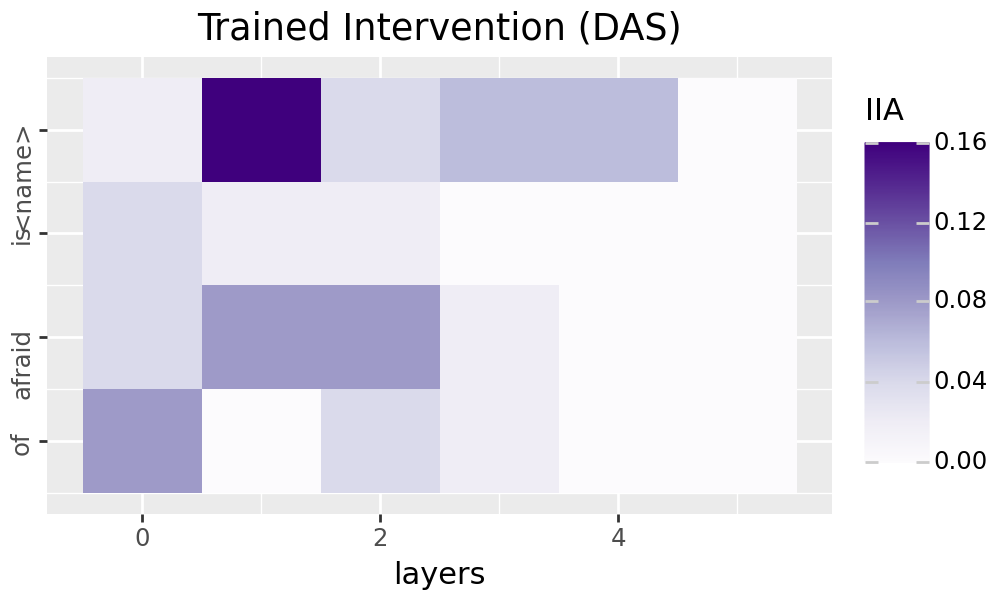

In [114]:
df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_das.csv")
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["IIA"] = df["iia"].astype(float)

custom_labels = ["<name>", "is", "afraid", "of", "<animal>"]
breaks = [0, 1, 2, 3, 4]

plot = (
    ggplot(df, aes(x="layer", y="pos"))
    + geom_tile(aes(fill="IIA"))
    + scale_fill_cmap("Purples") + xlab("layers")
    + scale_y_reverse(
        limits = (-0.5, 3.5),
        breaks=breaks, labels=custom_labels)
    + theme(figure_size=(5, 3)) + ylab("")
    + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    + ggtitle("Trained Intervention (DAS)")
)
ggsave(
    plot, filename=f"/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_das.pdf", dpi=200
)
display(plot)

## Probing

We'll define a dummy intervention `CollectActivation` to collect activations and train a simple probe.

In [115]:
def probing_config(intervention_site, layer):
    """Generate intervention config."""

    # init
    config = pv.IntervenableConfig([{
        "layer": layer,
        "component": intervention_site,
        "intervention_type": pv.CollectIntervention,
    }])
    return config

This is the training loop.

In [116]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
import torch
from tqdm import tqdm
import pandas as pd
from collections import Counter

# ===================================================
# 1) VERIFYING THE LABEL_MAPPING
# ===================================================
# Print tokens for the specified words to ensure that
# the IDs match the defined label_mapping.
label_mapping = {
    8076: 0,   # cat
    38718: 0,  # cats
    19618: 1,  # mouse
    40995: 2   # wolf
}

print("=== DEBUG: label_mapping and actual model tokens ===")
words_to_check = ["mouse", "cat", "wolf", "cats"]
for word in words_to_check:
    tokens = tokenizer.encode(word, add_special_tokens=False)
    print(f"'{word}' -> {tokens}")
print("label_mapping:", label_mapping)
print("===================================================\n")

# Debug input data
print("\nSample data from trainset:")
for ex in trainset[:5]:
    print("Base sample:", ex.base)
    print("Source sample:", ex.src)
    print("Base label:", ex.base_label, "->", tokenizer.decode([ex.base_label]))
    print("Source label:", ex.src_label, "->", tokenizer.decode([ex.src_label]))

print("\nSample data from evalset:")
for ex in evalset[:5]:
    print("Base sample:", ex.base)
    print("Source sample:", ex.src)
    print("Base label:", ex.base_label, "->", tokenizer.decode([ex.base_label]))
    print("Source label:", ex.src_label, "->", tokenizer.decode([ex.src_label]))

# ===================================================
# 2) DATASET DIAGNOSTICS (trainset, evalset)
# ===================================================

def remove_duplicates(trainset, evalset):
    # Convert trainset and evalset to sets of tuples for comparison
    train_samples_str = set([
        (tuple(ex.base["input_ids"][0].tolist()), tuple(ex.src["input_ids"][0].tolist()))
        for ex in trainset
    ])
    eval_samples_str = set([
        (tuple(ex.base["input_ids"][0].tolist()), tuple(ex.src["input_ids"][0].tolist()))
        for ex in evalset
    ])

    # Find duplicates between trainset and evalset
    common = train_samples_str.intersection(eval_samples_str)
    print(f"\nNumber of duplicates between trainset and evalset: {len(common)}")

    # Remove duplicates from evalset if any
    if len(common) > 0:
        print("WARNING: Removing duplicates from evalset...\n")
        evalset = [
            ex for ex in evalset
            if (tuple(ex.base["input_ids"][0].tolist()), tuple(ex.src["input_ids"][0].tolist())) not in common
        ]
    else:
        print("OK: No duplicates between trainset and evalset.\n")

    return trainset, evalset

# 1) Remove duplicates
trainset, evalset = remove_duplicates(trainset, evalset)

# 2) Build label lists for trainset and evalset
train_text_labels = []
for ex in trainset:
    train_text_labels.append(ex.base_label)
    train_text_labels.append(ex.src_label)

eval_text_labels = []
for ex in evalset:
    eval_text_labels.append(ex.base_label)
    eval_text_labels.append(ex.src_label)

# Debug: Check label distribution
print("Label distribution (IDs) in trainset:", Counter(train_text_labels))
print("Label distribution (IDs) in evalset:", Counter(eval_text_labels))

# 3) Balance the dataset
balanced_trainset = []
for label in set(train_text_labels):
    label_samples = [ex for ex in trainset if ex.base_label == label or ex.src_label == label]
    balanced_trainset.extend(resample(label_samples, replace=True, n_samples=200, random_state=42))
trainset = balanced_trainset

print(f"\nAfter balancing: Number of samples in trainset: {len(trainset)}")
print(f"Number of samples in evalset: {len(evalset)}")

# Count label occurrences in train and eval datasets
train_text_labels = []
for ex in trainset:
    train_text_labels.append(ex.base_label)
    train_text_labels.append(ex.src_label)

eval_text_labels = []
for ex in evalset:
    eval_text_labels.append(ex.base_label)
    eval_text_labels.append(ex.src_label)

print("Label distribution (IDs) in trainset:", Counter(train_text_labels))
print("Label distribution (IDs) in evalset:", Counter(eval_text_labels))

# ===================================================
# 3) MAIN PROBING CODE
# ===================================================
stats = []
num_layers = gpt.config.num_hidden_layers

# Ensure label_mapping IDs match the above tokens
with torch.no_grad():
    for layer in range(num_layers):
        for position in range(4):
            print(f"==== layer: {layer}, position: {position} ====")

            # Set up intervenable model
            config = probing_config("block_output", layer)
            intervenable = pv.IntervenableModel(config, gpt)
            intervenable.set_device(device)
            intervenable.disable_model_gradients()

            # ===========================
            # COLLECT TRAINING DATA
            # ===========================
            train_activations, train_labels_ids = [], []
            iterator = tqdm(trainset, desc="Collecting TRAIN activations")
            for example in iterator:
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]

                train_activations.extend([
                    base_activations.detach()[0].cpu().numpy(),
                    src_activations.detach()[0].cpu().numpy()
                ])
                train_labels_ids.extend([example.base_label, example.src_label])

            # Map train labels using label_mapping
            train_labels_mapped = []
            for lb in train_labels_ids:
                if isinstance(lb, list):
                    lb = tuple(lb)
                if lb not in label_mapping:
                    continue
                train_labels_mapped.append(label_mapping[lb])

            train_activations = np.array(train_activations)
            train_labels_mapped = np.array(train_labels_mapped)

            scaler = StandardScaler()
            train_activations_scaled = scaler.fit_transform(train_activations)

            # Collect activation statistics
            activations_sample = []
            for example in trainset[:5]:
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": 0},
                )
                activations_sample.append(base_outputs[1][0].detach().cpu().numpy())

            print("\nActivations (layer 0, position 0):", activations_sample[:3])
            print("Mean activation:", np.mean(activations_sample))
            print("Standard deviation:", np.std(activations_sample))

            # ===========================
            # TRAINING LOGISTIC REGRESSION / MLP
            # ===========================
            mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, alpha=1e-4, early_stopping=True, random_state=42)
            mlp.fit(train_activations_scaled, train_labels_mapped)

            # =========================
            # COLLECT EVAL DATA
            # =========================
            eval_activations, eval_labels_ids = [], []
            iterator = tqdm(evalset, desc="Collecting EVAL activations")
            for example in iterator:
                base_outputs, _ = intervenable(
                    example.base,
                    unit_locations={"base": position},
                )
                base_activations = base_outputs[1][0]

                src_outputs, _ = intervenable(
                    example.src,
                    unit_locations={"base": position},
                )
                src_activations = src_outputs[1][0]

                eval_activations.extend([
                    base_activations.detach()[0].cpu().numpy(),
                    src_activations.detach()[0].cpu().numpy()
                ])
                eval_labels_ids.extend([example.base_label, example.src_label])

            eval_labels_mapped = []
            for lb in eval_labels_ids:
                if isinstance(lb, list):
                    lb = tuple(lb)
                if lb not in label_mapping:
                    continue
                eval_labels_mapped.append(label_mapping[lb])

            eval_activations = np.array(eval_activations)
            eval_labels_mapped = np.array(eval_labels_mapped)

            eval_activations_scaled = scaler.transform(eval_activations)

            preds = mlp.predict(eval_activations_scaled)
            acc = (preds == eval_labels_mapped).mean()
            f1 = f1_score(eval_labels_mapped, preds, average="micro")

            stats.append({
                "layer": layer,
                "position": position,
                "acc": acc,
                "f1": f1
            })
            print(f"[layer={layer}, pos={position}] ACC: {acc:.3%}, F1: {f1:.3f}")

            # Debugging predictions
            for i, (pred, true) in enumerate(zip(preds, eval_labels_mapped)):
                if pred != true:
                    print(f"Error in sample {i}: pred={pred}, true={true}")

# SAVE RESULTS
df = pd.DataFrame(stats)
df.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_probe.csv", index=False)
print("\nResults statistics (first 5 rows):")
print(df.head(5))


=== DEBUG: label_mapping a realne tokeny modelu ===
'mouse' -> [19618]
'cat' -> [8076]
'wolf' -> [40995]
'cats' -> [38718]
label_mapping: {8076: 0, 38718: 0, 19618: 1, 40995: 2}


Przykładowe dane z trainset:
Base sample: {'input_ids': tensor([[   40,   797,    83,  2496,   310,  9202,   273,  5798,    15,  1500,
           554,   403,  9202,   273, 36162,    15, 33133,   403,  9202,   273,
         16581,    15,   330,  1832,   403,  9202,   273, 16396,    15,   411,
         14503,   403,  9202,   273, 16581,    15, 29489,   310,   247,  5798,
            15, 47442,    83,  2496,   310,   247,  5798,    15, 24504,   310,
           247, 16396,    15, 12932,  8440,   310,   247,   209]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
Source sample: {'input_ids': tensor([[


Aktywacje (warstwa 0, pozycja 0): [array([[-3.97380739e-02, -2.35330150e-01, -2.98733503e-01,
        -2.19487816e-01, -1.60127252e-01, -4.07346487e-02,
         3.93424742e-03,  1.91739529e-01, -3.70883167e-01,
        -7.64219016e-02,  1.17070131e-01, -5.90757728e-02,
         3.48372102e-01, -1.34553358e-01,  6.85872197e-01,
        -1.42246783e-02,  3.16244364e-03,  4.01053250e-01,
         1.67660132e-01, -1.98817730e-01,  4.73764539e-02,
        -3.80505145e-01, -3.42554539e-01,  3.55103731e-01,
         1.84460223e-01,  9.79221761e-02, -1.87909119e-02,
        -3.47755194e-01, -4.95801449e-01,  1.95669338e-01,
        -2.44549245e-01, -2.47302368e-01, -4.75855917e-02,
         7.22805038e-04,  9.61014628e-03, -1.27108097e-02,
         5.32179296e-01,  2.29830503e-01,  9.92811620e-02,
         1.92441329e-01, -5.23788154e-01, -3.47576141e-01,
         1.25279307e-01,  1.95264101e-01, -1.65293008e-01,
        -8.42208862e-02,  2.43815586e-01,  1.26870885e-01,
        -5.78250065e

[layer=0, pos=0] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[-3.97380739e-02, -2.35330150e-01, -2.98733503e-01,
        -2.19487816e-01, -1.60127252e-01, -4.07346487e-02,
         3.93424742e-03,  1.91739529e-01, -3.70883167e-01,
        -7.64219016e-02,  1.17070131e-01, -5.90757728e-02,
         3.48372102e-01, -1.34553358e-01,  6.85872197e-01,
        -1.42246783e-02,  3.16244364e-03,  4.01053250e-01,
         1.67660132e-01, -1.98817730e-01,  4.73764539e-02,
        -3.80505145e-01, -3.42554539e-01,  3.55103731e-01,
         1.84460223e-01,  9.79221761e-02, -1.87909119e-02,
        -3.47755194e-01, -4.95801449e-01,  1.95669338e-01,
        -2.44549245e-01, -2.47302368e-01, -4.75855917e-02,
         7.22805038e-04,  9.61014628e-03, -1.27108097e-02,
         5.32179296e-01,  2.29830503e-01,  9.92811620e-02,
         1.92441329e-01, -5.23788154e-01, -3.47576141e-01,
         1.25279307e-01,  1.95264101e-01, -1.65293008e-01,
        -8.42208862e-02,  2.43815586e-01,  1.26870885e-01,
        -5.78250065e

[layer=0, pos=1] ACC: 41.667%, F1: 0.417
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 45: pred=0, true=2
Błąd w próbce 46: pred=1, true=0
Błąd w p


Aktywacje (warstwa 0, pozycja 0): [array([[-3.97380739e-02, -2.35330150e-01, -2.98733503e-01,
        -2.19487816e-01, -1.60127252e-01, -4.07346487e-02,
         3.93424742e-03,  1.91739529e-01, -3.70883167e-01,
        -7.64219016e-02,  1.17070131e-01, -5.90757728e-02,
         3.48372102e-01, -1.34553358e-01,  6.85872197e-01,
        -1.42246783e-02,  3.16244364e-03,  4.01053250e-01,
         1.67660132e-01, -1.98817730e-01,  4.73764539e-02,
        -3.80505145e-01, -3.42554539e-01,  3.55103731e-01,
         1.84460223e-01,  9.79221761e-02, -1.87909119e-02,
        -3.47755194e-01, -4.95801449e-01,  1.95669338e-01,
        -2.44549245e-01, -2.47302368e-01, -4.75855917e-02,
         7.22805038e-04,  9.61014628e-03, -1.27108097e-02,
         5.32179296e-01,  2.29830503e-01,  9.92811620e-02,
         1.92441329e-01, -5.23788154e-01, -3.47576141e-01,
         1.25279307e-01,  1.95264101e-01, -1.65293008e-01,
        -8.42208862e-02,  2.43815586e-01,  1.26870885e-01,
        -5.78250065e

[layer=0, pos=2] ACC: 36.458%, F1: 0.365
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 7: pred=0, true=1
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 13: pred=0, true=1
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 16: pred=0, true=1
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 20: pred=0, true=1
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 22: pred=0, true=1
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=0, true=2
Błąd w próbce 26: pred=0, true=2
Błąd w próbce 27: pred=0, true=1
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 34: pred=0, true=1
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=0, true=2
Błąd w próbce 40: pred=0, true=1
Błąd w próbce 43: pred=0, true=1
Błąd w 


Aktywacje (warstwa 0, pozycja 0): [array([[-3.97380739e-02, -2.35330150e-01, -2.98733503e-01,
        -2.19487816e-01, -1.60127252e-01, -4.07346487e-02,
         3.93424742e-03,  1.91739529e-01, -3.70883167e-01,
        -7.64219016e-02,  1.17070131e-01, -5.90757728e-02,
         3.48372102e-01, -1.34553358e-01,  6.85872197e-01,
        -1.42246783e-02,  3.16244364e-03,  4.01053250e-01,
         1.67660132e-01, -1.98817730e-01,  4.73764539e-02,
        -3.80505145e-01, -3.42554539e-01,  3.55103731e-01,
         1.84460223e-01,  9.79221761e-02, -1.87909119e-02,
        -3.47755194e-01, -4.95801449e-01,  1.95669338e-01,
        -2.44549245e-01, -2.47302368e-01, -4.75855917e-02,
         7.22805038e-04,  9.61014628e-03, -1.27108097e-02,
         5.32179296e-01,  2.29830503e-01,  9.92811620e-02,
         1.92441329e-01, -5.23788154e-01, -3.47576141e-01,
         1.25279307e-01,  1.95264101e-01, -1.65293008e-01,
        -8.42208862e-02,  2.43815586e-01,  1.26870885e-01,
        -5.78250065e

[layer=0, pos=3] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.10110080e-01, -9.82041508e-02, -2.09760845e-01,
        -1.54209185e+00,  4.02074486e-01,  1.89474678e+00,
         5.17897964e-01, -8.38311195e-01, -3.06382596e-01,
        -7.03126490e-01, -9.01969254e-01,  8.67204517e-02,
         1.72163761e+00,  5.12599796e-02,  4.45938528e-01,
         6.08454943e-01, -4.76759255e-01,  1.20388234e+00,
         8.23617876e-02,  2.32116640e-01,  1.05502456e-03,
        -1.64632320e+00, -6.84102774e-02,  7.89977646e+00,
         3.90065312e-02,  1.11544311e+00, -2.44027686e+00,
        -4.78435844e-01, -2.51705885e-01, -8.67478698e-02,
         2.28086621e-01,  1.38043270e-01,  1.17618251e+00,
         5.06239235e-01,  9.48018074e-01,  1.25424135e+00,
         1.71788144e+00,  3.91487241e-01, -1.37019849e+00,
        -1.15700901e+00,  8.01679492e-02, -7.78546333e-01,
         1.39485216e+00,  1.07491469e+00,  5.82396746e-01,
         1.14365697e+00, -5.93497753e-01, -2.84106135e-02,
         1.22792447e

[layer=1, pos=0] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.10110080e-01, -9.82041508e-02, -2.09760845e-01,
        -1.54209185e+00,  4.02074486e-01,  1.89474678e+00,
         5.17897964e-01, -8.38311195e-01, -3.06382596e-01,
        -7.03126490e-01, -9.01969254e-01,  8.67204517e-02,
         1.72163761e+00,  5.12599796e-02,  4.45938528e-01,
         6.08454943e-01, -4.76759255e-01,  1.20388234e+00,
         8.23617876e-02,  2.32116640e-01,  1.05502456e-03,
        -1.64632320e+00, -6.84102774e-02,  7.89977646e+00,
         3.90065312e-02,  1.11544311e+00, -2.44027686e+00,
        -4.78435844e-01, -2.51705885e-01, -8.67478698e-02,
         2.28086621e-01,  1.38043270e-01,  1.17618251e+00,
         5.06239235e-01,  9.48018074e-01,  1.25424135e+00,
         1.71788144e+00,  3.91487241e-01, -1.37019849e+00,
        -1.15700901e+00,  8.01679492e-02, -7.78546333e-01,
         1.39485216e+00,  1.07491469e+00,  5.82396746e-01,
         1.14365697e+00, -5.93497753e-01, -2.84106135e-02,
         1.22792447e

[layer=1, pos=1] ACC: 42.708%, F1: 0.427
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 4: pred=2, true=0
Błąd w próbce 5: pred=2, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=2, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 14: pred=2, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 28: pred=2, true=0
Błąd w próbce 29: pred=2, true=1
Błąd w próbce 31: pred=2, true=0
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 46: pred=1, true=0
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.10110080e-01, -9.82041508e-02, -2.09760845e-01,
        -1.54209185e+00,  4.02074486e-01,  1.89474678e+00,
         5.17897964e-01, -8.38311195e-01, -3.06382596e-01,
        -7.03126490e-01, -9.01969254e-01,  8.67204517e-02,
         1.72163761e+00,  5.12599796e-02,  4.45938528e-01,
         6.08454943e-01, -4.76759255e-01,  1.20388234e+00,
         8.23617876e-02,  2.32116640e-01,  1.05502456e-03,
        -1.64632320e+00, -6.84102774e-02,  7.89977646e+00,
         3.90065312e-02,  1.11544311e+00, -2.44027686e+00,
        -4.78435844e-01, -2.51705885e-01, -8.67478698e-02,
         2.28086621e-01,  1.38043270e-01,  1.17618251e+00,
         5.06239235e-01,  9.48018074e-01,  1.25424135e+00,
         1.71788144e+00,  3.91487241e-01, -1.37019849e+00,
        -1.15700901e+00,  8.01679492e-02, -7.78546333e-01,
         1.39485216e+00,  1.07491469e+00,  5.82396746e-01,
         1.14365697e+00, -5.93497753e-01, -2.84106135e-02,
         1.22792447e

[layer=1, pos=2] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.10110080e-01, -9.82041508e-02, -2.09760845e-01,
        -1.54209185e+00,  4.02074486e-01,  1.89474678e+00,
         5.17897964e-01, -8.38311195e-01, -3.06382596e-01,
        -7.03126490e-01, -9.01969254e-01,  8.67204517e-02,
         1.72163761e+00,  5.12599796e-02,  4.45938528e-01,
         6.08454943e-01, -4.76759255e-01,  1.20388234e+00,
         8.23617876e-02,  2.32116640e-01,  1.05502456e-03,
        -1.64632320e+00, -6.84102774e-02,  7.89977646e+00,
         3.90065312e-02,  1.11544311e+00, -2.44027686e+00,
        -4.78435844e-01, -2.51705885e-01, -8.67478698e-02,
         2.28086621e-01,  1.38043270e-01,  1.17618251e+00,
         5.06239235e-01,  9.48018074e-01,  1.25424135e+00,
         1.71788144e+00,  3.91487241e-01, -1.37019849e+00,
        -1.15700901e+00,  8.01679492e-02, -7.78546333e-01,
         1.39485216e+00,  1.07491469e+00,  5.82396746e-01,
         1.14365697e+00, -5.93497753e-01, -2.84106135e-02,
         1.22792447e

[layer=1, pos=3] ACC: 41.667%, F1: 0.417
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 45: pred=0, true=2
Błąd w próbce 46: pred=1, true=0
Błąd w p


Aktywacje (warstwa 0, pozycja 0): [array([[ 8.40010285e-01, -1.33148873e+00,  7.21548975e-01,
         7.27634907e-01,  1.56512868e+00, -4.12762165e-02,
         6.07237756e-01, -1.30057764e+00, -1.33909369e+00,
         8.03305566e-01, -5.54729819e-01, -3.53549600e-01,
         9.43980217e-01,  1.49989441e-01,  1.99749064e+00,
         3.72741580e-01, -1.34426701e+00, -5.17058969e-01,
         6.63184404e-01, -5.23340940e-01,  2.44177699e+00,
        -9.61114883e-01, -3.64908099e-01,  8.33839722e+01,
         1.86647987e+00,  1.37142730e+00, -1.73112404e+00,
        -1.57312715e+00, -4.11599874e-03, -6.42848134e-01,
         1.34806550e+00, -1.78360498e+00,  1.34791946e+00,
        -3.32627892e-01,  1.44291854e+00, -9.12337661e-01,
         1.42489791e-01, -2.64564753e-01, -3.25892258e+00,
        -2.57407045e+00,  7.83766925e-01, -7.87817597e-01,
         8.39504719e-01, -5.08328915e-01, -7.75758743e-01,
         9.60478365e-01, -5.94208479e-01,  1.57167941e-01,
        -6.32912517e

[layer=2, pos=0] ACC: 36.458%, F1: 0.365
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 7: pred=0, true=1
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 13: pred=0, true=1
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 16: pred=0, true=1
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 20: pred=0, true=1
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 22: pred=0, true=1
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=0, true=2
Błąd w próbce 26: pred=0, true=2
Błąd w próbce 27: pred=0, true=1
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 34: pred=0, true=1
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=0, true=2
Błąd w próbce 40: pred=0, true=1
Błąd w próbce 43: pred=0, true=1
Błąd w 


Aktywacje (warstwa 0, pozycja 0): [array([[ 8.40010285e-01, -1.33148873e+00,  7.21548975e-01,
         7.27634907e-01,  1.56512868e+00, -4.12762165e-02,
         6.07237756e-01, -1.30057764e+00, -1.33909369e+00,
         8.03305566e-01, -5.54729819e-01, -3.53549600e-01,
         9.43980217e-01,  1.49989441e-01,  1.99749064e+00,
         3.72741580e-01, -1.34426701e+00, -5.17058969e-01,
         6.63184404e-01, -5.23340940e-01,  2.44177699e+00,
        -9.61114883e-01, -3.64908099e-01,  8.33839722e+01,
         1.86647987e+00,  1.37142730e+00, -1.73112404e+00,
        -1.57312715e+00, -4.11599874e-03, -6.42848134e-01,
         1.34806550e+00, -1.78360498e+00,  1.34791946e+00,
        -3.32627892e-01,  1.44291854e+00, -9.12337661e-01,
         1.42489791e-01, -2.64564753e-01, -3.25892258e+00,
        -2.57407045e+00,  7.83766925e-01, -7.87817597e-01,
         8.39504719e-01, -5.08328915e-01, -7.75758743e-01,
         9.60478365e-01, -5.94208479e-01,  1.57167941e-01,
        -6.32912517e

[layer=2, pos=1] ACC: 41.667%, F1: 0.417
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 45: pred=0, true=2
Błąd w próbce 46: pred=1, true=0
Błąd w p


Aktywacje (warstwa 0, pozycja 0): [array([[ 8.40010285e-01, -1.33148873e+00,  7.21548975e-01,
         7.27634907e-01,  1.56512868e+00, -4.12762165e-02,
         6.07237756e-01, -1.30057764e+00, -1.33909369e+00,
         8.03305566e-01, -5.54729819e-01, -3.53549600e-01,
         9.43980217e-01,  1.49989441e-01,  1.99749064e+00,
         3.72741580e-01, -1.34426701e+00, -5.17058969e-01,
         6.63184404e-01, -5.23340940e-01,  2.44177699e+00,
        -9.61114883e-01, -3.64908099e-01,  8.33839722e+01,
         1.86647987e+00,  1.37142730e+00, -1.73112404e+00,
        -1.57312715e+00, -4.11599874e-03, -6.42848134e-01,
         1.34806550e+00, -1.78360498e+00,  1.34791946e+00,
        -3.32627892e-01,  1.44291854e+00, -9.12337661e-01,
         1.42489791e-01, -2.64564753e-01, -3.25892258e+00,
        -2.57407045e+00,  7.83766925e-01, -7.87817597e-01,
         8.39504719e-01, -5.08328915e-01, -7.75758743e-01,
         9.60478365e-01, -5.94208479e-01,  1.57167941e-01,
        -6.32912517e

[layer=2, pos=2] ACC: 34.375%, F1: 0.344
Błąd w próbce 0: pred=1, true=0
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=1, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=1, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=1, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=1, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 41: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 8.40010285e-01, -1.33148873e+00,  7.21548975e-01,
         7.27634907e-01,  1.56512868e+00, -4.12762165e-02,
         6.07237756e-01, -1.30057764e+00, -1.33909369e+00,
         8.03305566e-01, -5.54729819e-01, -3.53549600e-01,
         9.43980217e-01,  1.49989441e-01,  1.99749064e+00,
         3.72741580e-01, -1.34426701e+00, -5.17058969e-01,
         6.63184404e-01, -5.23340940e-01,  2.44177699e+00,
        -9.61114883e-01, -3.64908099e-01,  8.33839722e+01,
         1.86647987e+00,  1.37142730e+00, -1.73112404e+00,
        -1.57312715e+00, -4.11599874e-03, -6.42848134e-01,
         1.34806550e+00, -1.78360498e+00,  1.34791946e+00,
        -3.32627892e-01,  1.44291854e+00, -9.12337661e-01,
         1.42489791e-01, -2.64564753e-01, -3.25892258e+00,
        -2.57407045e+00,  7.83766925e-01, -7.87817597e-01,
         8.39504719e-01, -5.08328915e-01, -7.75758743e-01,
         9.60478365e-01, -5.94208479e-01,  1.57167941e-01,
        -6.32912517e

[layer=2, pos=3] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.28614712e+00, -9.38163996e-02,  2.28408039e-01,
        -1.63712502e-01,  2.62448597e+00, -4.95629430e-01,
         3.19307208e-01, -9.83655572e-01, -1.02515829e+00,
        -3.86918843e-01, -1.09590209e+00, -2.71114469e-01,
         1.52648878e+00, -9.26174343e-01,  2.21227217e+00,
         4.12531346e-01, -4.29520965e-01, -3.15971255e-01,
         7.76755631e-01,  1.10947073e-01,  2.75174689e+00,
        -1.20405579e+00, -4.19857979e-01,  7.55582581e+01,
         1.45248377e+00,  2.48221779e+00, -1.23441792e+00,
        -9.24266875e-01, -7.55276442e-01, -7.28266835e-02,
         3.13199043e-01, -3.09837723e+00,  1.06514692e+00,
        -3.27120751e-01,  1.37523639e+00, -2.02569222e+00,
         1.06681317e-01,  4.63050127e-01, -2.63493228e+00,
        -2.63349938e+00,  4.48780358e-01, -9.12365794e-01,
         1.25107265e+00, -5.97844124e-01, -9.40275311e-01,
        -1.16394818e-01, -1.28552938e+00, -4.13042277e-01,
        -5.15759766e

[layer=3, pos=0] ACC: 34.375%, F1: 0.344
Błąd w próbce 0: pred=1, true=0
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=1, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=1, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=1, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=1, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 41: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.28614712e+00, -9.38163996e-02,  2.28408039e-01,
        -1.63712502e-01,  2.62448597e+00, -4.95629430e-01,
         3.19307208e-01, -9.83655572e-01, -1.02515829e+00,
        -3.86918843e-01, -1.09590209e+00, -2.71114469e-01,
         1.52648878e+00, -9.26174343e-01,  2.21227217e+00,
         4.12531346e-01, -4.29520965e-01, -3.15971255e-01,
         7.76755631e-01,  1.10947073e-01,  2.75174689e+00,
        -1.20405579e+00, -4.19857979e-01,  7.55582581e+01,
         1.45248377e+00,  2.48221779e+00, -1.23441792e+00,
        -9.24266875e-01, -7.55276442e-01, -7.28266835e-02,
         3.13199043e-01, -3.09837723e+00,  1.06514692e+00,
        -3.27120751e-01,  1.37523639e+00, -2.02569222e+00,
         1.06681317e-01,  4.63050127e-01, -2.63493228e+00,
        -2.63349938e+00,  4.48780358e-01, -9.12365794e-01,
         1.25107265e+00, -5.97844124e-01, -9.40275311e-01,
        -1.16394818e-01, -1.28552938e+00, -4.13042277e-01,
        -5.15759766e

[layer=3, pos=1] ACC: 41.667%, F1: 0.417
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 45: pred=0, true=2
Błąd w próbce 46: pred=1, true=0
Błąd w p


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.28614712e+00, -9.38163996e-02,  2.28408039e-01,
        -1.63712502e-01,  2.62448597e+00, -4.95629430e-01,
         3.19307208e-01, -9.83655572e-01, -1.02515829e+00,
        -3.86918843e-01, -1.09590209e+00, -2.71114469e-01,
         1.52648878e+00, -9.26174343e-01,  2.21227217e+00,
         4.12531346e-01, -4.29520965e-01, -3.15971255e-01,
         7.76755631e-01,  1.10947073e-01,  2.75174689e+00,
        -1.20405579e+00, -4.19857979e-01,  7.55582581e+01,
         1.45248377e+00,  2.48221779e+00, -1.23441792e+00,
        -9.24266875e-01, -7.55276442e-01, -7.28266835e-02,
         3.13199043e-01, -3.09837723e+00,  1.06514692e+00,
        -3.27120751e-01,  1.37523639e+00, -2.02569222e+00,
         1.06681317e-01,  4.63050127e-01, -2.63493228e+00,
        -2.63349938e+00,  4.48780358e-01, -9.12365794e-01,
         1.25107265e+00, -5.97844124e-01, -9.40275311e-01,
        -1.16394818e-01, -1.28552938e+00, -4.13042277e-01,
        -5.15759766e

[layer=3, pos=2] ACC: 41.667%, F1: 0.417
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 45: pred=0, true=2
Błąd w próbce 46: pred=1, true=0
Błąd w p


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.28614712e+00, -9.38163996e-02,  2.28408039e-01,
        -1.63712502e-01,  2.62448597e+00, -4.95629430e-01,
         3.19307208e-01, -9.83655572e-01, -1.02515829e+00,
        -3.86918843e-01, -1.09590209e+00, -2.71114469e-01,
         1.52648878e+00, -9.26174343e-01,  2.21227217e+00,
         4.12531346e-01, -4.29520965e-01, -3.15971255e-01,
         7.76755631e-01,  1.10947073e-01,  2.75174689e+00,
        -1.20405579e+00, -4.19857979e-01,  7.55582581e+01,
         1.45248377e+00,  2.48221779e+00, -1.23441792e+00,
        -9.24266875e-01, -7.55276442e-01, -7.28266835e-02,
         3.13199043e-01, -3.09837723e+00,  1.06514692e+00,
        -3.27120751e-01,  1.37523639e+00, -2.02569222e+00,
         1.06681317e-01,  4.63050127e-01, -2.63493228e+00,
        -2.63349938e+00,  4.48780358e-01, -9.12365794e-01,
         1.25107265e+00, -5.97844124e-01, -9.40275311e-01,
        -1.16394818e-01, -1.28552938e+00, -4.13042277e-01,
        -5.15759766e

[layer=3, pos=3] ACC: 42.708%, F1: 0.427
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 4: pred=2, true=0
Błąd w próbce 5: pred=2, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=2, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 14: pred=2, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 28: pred=2, true=0
Błąd w próbce 29: pred=2, true=1
Błąd w próbce 31: pred=2, true=0
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 46: pred=1, true=0
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.08926392e-01, -2.36230898e+00, -3.09208453e-01,
        -1.13173097e-01,  7.09339619e-01, -7.43913651e-01,
         2.94788957e-01, -3.16070795e-01, -5.24973869e-03,
        -4.95609403e-01, -3.57327342e-01,  5.38521409e-01,
         1.05305207e+00, -2.76353717e-01,  9.74577188e-01,
         2.55873770e-01,  1.42094254e-01,  4.04461086e-01,
        -2.19531775e-01, -3.76701444e-01,  3.60036945e+00,
        -2.57101917e+00,  7.63112783e-01,  4.65989761e+01,
         1.12415397e+00,  3.05700612e+00, -1.13181686e+00,
        -3.59379470e-01, -1.92493260e+00, -7.30659783e-01,
         2.80806452e-01, -1.79503167e+00,  8.50652575e-01,
        -2.16559663e-01,  4.87278700e-01, -1.14090669e+00,
        -6.76909834e-02, -3.98854613e-02, -1.39124501e+00,
        -1.32140148e+00,  7.35798240e-01, -1.78139150e+00,
         1.08636928e+00, -3.21991920e-01,  4.43640351e-01,
         7.13456988e-01, -4.90352154e-01,  7.35953331e-01,
        -1.76066071e

[layer=4, pos=0] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.08926392e-01, -2.36230898e+00, -3.09208453e-01,
        -1.13173097e-01,  7.09339619e-01, -7.43913651e-01,
         2.94788957e-01, -3.16070795e-01, -5.24973869e-03,
        -4.95609403e-01, -3.57327342e-01,  5.38521409e-01,
         1.05305207e+00, -2.76353717e-01,  9.74577188e-01,
         2.55873770e-01,  1.42094254e-01,  4.04461086e-01,
        -2.19531775e-01, -3.76701444e-01,  3.60036945e+00,
        -2.57101917e+00,  7.63112783e-01,  4.65989761e+01,
         1.12415397e+00,  3.05700612e+00, -1.13181686e+00,
        -3.59379470e-01, -1.92493260e+00, -7.30659783e-01,
         2.80806452e-01, -1.79503167e+00,  8.50652575e-01,
        -2.16559663e-01,  4.87278700e-01, -1.14090669e+00,
        -6.76909834e-02, -3.98854613e-02, -1.39124501e+00,
        -1.32140148e+00,  7.35798240e-01, -1.78139150e+00,
         1.08636928e+00, -3.21991920e-01,  4.43640351e-01,
         7.13456988e-01, -4.90352154e-01,  7.35953331e-01,
        -1.76066071e

[layer=4, pos=1] ACC: 41.667%, F1: 0.417
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 45: pred=0, true=2
Błąd w próbce 46: pred=1, true=0
Błąd w p


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.08926392e-01, -2.36230898e+00, -3.09208453e-01,
        -1.13173097e-01,  7.09339619e-01, -7.43913651e-01,
         2.94788957e-01, -3.16070795e-01, -5.24973869e-03,
        -4.95609403e-01, -3.57327342e-01,  5.38521409e-01,
         1.05305207e+00, -2.76353717e-01,  9.74577188e-01,
         2.55873770e-01,  1.42094254e-01,  4.04461086e-01,
        -2.19531775e-01, -3.76701444e-01,  3.60036945e+00,
        -2.57101917e+00,  7.63112783e-01,  4.65989761e+01,
         1.12415397e+00,  3.05700612e+00, -1.13181686e+00,
        -3.59379470e-01, -1.92493260e+00, -7.30659783e-01,
         2.80806452e-01, -1.79503167e+00,  8.50652575e-01,
        -2.16559663e-01,  4.87278700e-01, -1.14090669e+00,
        -6.76909834e-02, -3.98854613e-02, -1.39124501e+00,
        -1.32140148e+00,  7.35798240e-01, -1.78139150e+00,
         1.08636928e+00, -3.21991920e-01,  4.43640351e-01,
         7.13456988e-01, -4.90352154e-01,  7.35953331e-01,
        -1.76066071e

[layer=4, pos=2] ACC: 41.667%, F1: 0.417
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 45: pred=0, true=2
Błąd w próbce 46: pred=1, true=0
Błąd w p


Aktywacje (warstwa 0, pozycja 0): [array([[ 5.08926392e-01, -2.36230898e+00, -3.09208453e-01,
        -1.13173097e-01,  7.09339619e-01, -7.43913651e-01,
         2.94788957e-01, -3.16070795e-01, -5.24973869e-03,
        -4.95609403e-01, -3.57327342e-01,  5.38521409e-01,
         1.05305207e+00, -2.76353717e-01,  9.74577188e-01,
         2.55873770e-01,  1.42094254e-01,  4.04461086e-01,
        -2.19531775e-01, -3.76701444e-01,  3.60036945e+00,
        -2.57101917e+00,  7.63112783e-01,  4.65989761e+01,
         1.12415397e+00,  3.05700612e+00, -1.13181686e+00,
        -3.59379470e-01, -1.92493260e+00, -7.30659783e-01,
         2.80806452e-01, -1.79503167e+00,  8.50652575e-01,
        -2.16559663e-01,  4.87278700e-01, -1.14090669e+00,
        -6.76909834e-02, -3.98854613e-02, -1.39124501e+00,
        -1.32140148e+00,  7.35798240e-01, -1.78139150e+00,
         1.08636928e+00, -3.21991920e-01,  4.43640351e-01,
         7.13456988e-01, -4.90352154e-01,  7.35953331e-01,
        -1.76066071e

[layer=4, pos=3] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.7277304e+00, -2.6706307e+00, -1.7842810e+00, -3.0495472e+00,
        -2.1156640e+00, -1.9883472e+00, -1.7120355e+00,  2.5888495e+00,
         1.4895780e+00, -2.6671181e+00, -3.5249467e+00, -1.6455599e+00,
        -1.6393369e+00,  1.6907960e+00,  4.3143024e+00,  2.9394472e+00,
        -3.4885955e+00, -2.1843896e+00,  1.9344292e+00, -1.5771266e+00,
         3.3444693e+00,  2.1799355e+00,  5.4958808e-01,  4.4003029e+00,
         3.4118147e+00,  2.1550152e+00, -4.0575418e+00,  2.4185784e+00,
         2.2101851e+00, -2.2700481e+00, -2.3466258e+00,  5.4725587e-01,
         3.9866357e+00,  1.6309930e+00, -2.8332584e+00, -2.3980746e+00,
        -4.3514866e-01,  5.6755823e-01,  2.7568016e+00, -2.1258528e+00,
        -1.7639219e+00,  1.9548568e+00, -2.5175169e+00,  2.5550227e+00,
        -1.4954277e+00, -2.5685658e+00,  2.7801077e+00,  2.5035102e+00,
         3.1105270e+00, -4.8606768e+00, -9.3460727e-01,  1.7896018e+00,
        -3.9096985e+00, -2.3

[layer=5, pos=0] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.7277304e+00, -2.6706307e+00, -1.7842810e+00, -3.0495472e+00,
        -2.1156640e+00, -1.9883472e+00, -1.7120355e+00,  2.5888495e+00,
         1.4895780e+00, -2.6671181e+00, -3.5249467e+00, -1.6455599e+00,
        -1.6393369e+00,  1.6907960e+00,  4.3143024e+00,  2.9394472e+00,
        -3.4885955e+00, -2.1843896e+00,  1.9344292e+00, -1.5771266e+00,
         3.3444693e+00,  2.1799355e+00,  5.4958808e-01,  4.4003029e+00,
         3.4118147e+00,  2.1550152e+00, -4.0575418e+00,  2.4185784e+00,
         2.2101851e+00, -2.2700481e+00, -2.3466258e+00,  5.4725587e-01,
         3.9866357e+00,  1.6309930e+00, -2.8332584e+00, -2.3980746e+00,
        -4.3514866e-01,  5.6755823e-01,  2.7568016e+00, -2.1258528e+00,
        -1.7639219e+00,  1.9548568e+00, -2.5175169e+00,  2.5550227e+00,
        -1.4954277e+00, -2.5685658e+00,  2.7801077e+00,  2.5035102e+00,
         3.1105270e+00, -4.8606768e+00, -9.3460727e-01,  1.7896018e+00,
        -3.9096985e+00, -2.3

[layer=5, pos=1] ACC: 42.708%, F1: 0.427
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=2, true=1
Błąd w próbce 4: pred=2, true=0
Błąd w próbce 5: pred=2, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=2, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=2, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 14: pred=2, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 19: pred=2, true=0
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=2, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 28: pred=2, true=0
Błąd w próbce 29: pred=2, true=1
Błąd w próbce 31: pred=2, true=0
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 35: pred=2, true=0
Błąd w próbce 36: pred=2, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 46: pred=1, true=0
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.7277304e+00, -2.6706307e+00, -1.7842810e+00, -3.0495472e+00,
        -2.1156640e+00, -1.9883472e+00, -1.7120355e+00,  2.5888495e+00,
         1.4895780e+00, -2.6671181e+00, -3.5249467e+00, -1.6455599e+00,
        -1.6393369e+00,  1.6907960e+00,  4.3143024e+00,  2.9394472e+00,
        -3.4885955e+00, -2.1843896e+00,  1.9344292e+00, -1.5771266e+00,
         3.3444693e+00,  2.1799355e+00,  5.4958808e-01,  4.4003029e+00,
         3.4118147e+00,  2.1550152e+00, -4.0575418e+00,  2.4185784e+00,
         2.2101851e+00, -2.2700481e+00, -2.3466258e+00,  5.4725587e-01,
         3.9866357e+00,  1.6309930e+00, -2.8332584e+00, -2.3980746e+00,
        -4.3514866e-01,  5.6755823e-01,  2.7568016e+00, -2.1258528e+00,
        -1.7639219e+00,  1.9548568e+00, -2.5175169e+00,  2.5550227e+00,
        -1.4954277e+00, -2.5685658e+00,  2.7801077e+00,  2.5035102e+00,
         3.1105270e+00, -4.8606768e+00, -9.3460727e-01,  1.7896018e+00,
        -3.9096985e+00, -2.3

[layer=5, pos=2] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr


Aktywacje (warstwa 0, pozycja 0): [array([[ 1.7277304e+00, -2.6706307e+00, -1.7842810e+00, -3.0495472e+00,
        -2.1156640e+00, -1.9883472e+00, -1.7120355e+00,  2.5888495e+00,
         1.4895780e+00, -2.6671181e+00, -3.5249467e+00, -1.6455599e+00,
        -1.6393369e+00,  1.6907960e+00,  4.3143024e+00,  2.9394472e+00,
        -3.4885955e+00, -2.1843896e+00,  1.9344292e+00, -1.5771266e+00,
         3.3444693e+00,  2.1799355e+00,  5.4958808e-01,  4.4003029e+00,
         3.4118147e+00,  2.1550152e+00, -4.0575418e+00,  2.4185784e+00,
         2.2101851e+00, -2.2700481e+00, -2.3466258e+00,  5.4725587e-01,
         3.9866357e+00,  1.6309930e+00, -2.8332584e+00, -2.3980746e+00,
        -4.3514866e-01,  5.6755823e-01,  2.7568016e+00, -2.1258528e+00,
        -1.7639219e+00,  1.9548568e+00, -2.5175169e+00,  2.5550227e+00,
        -1.4954277e+00, -2.5685658e+00,  2.7801077e+00,  2.5035102e+00,
         3.1105270e+00, -4.8606768e+00, -9.3460727e-01,  1.7896018e+00,
        -3.9096985e+00, -2.3

[layer=5, pos=3] ACC: 38.542%, F1: 0.385
Błąd w próbce 1: pred=0, true=1
Błąd w próbce 2: pred=0, true=1
Błąd w próbce 3: pred=0, true=2
Błąd w próbce 5: pred=0, true=1
Błąd w próbce 6: pred=1, true=0
Błąd w próbce 8: pred=0, true=1
Błąd w próbce 9: pred=1, true=0
Błąd w próbce 10: pred=0, true=1
Błąd w próbce 11: pred=1, true=0
Błąd w próbce 12: pred=0, true=2
Błąd w próbce 14: pred=0, true=1
Błąd w próbce 15: pred=1, true=0
Błąd w próbce 17: pred=0, true=2
Błąd w próbce 18: pred=0, true=2
Błąd w próbce 21: pred=0, true=2
Błąd w próbce 23: pred=1, true=0
Błąd w próbce 24: pred=0, true=1
Błąd w próbce 25: pred=1, true=2
Błąd w próbce 26: pred=1, true=2
Błąd w próbce 29: pred=0, true=1
Błąd w próbce 30: pred=0, true=2
Błąd w próbce 32: pred=1, true=0
Błąd w próbce 33: pred=0, true=2
Błąd w próbce 36: pred=0, true=1
Błąd w próbce 37: pred=0, true=2
Błąd w próbce 38: pred=1, true=2
Błąd w próbce 39: pred=1, true=0
Błąd w próbce 42: pred=0, true=2
Błąd w próbce 45: pred=0, true=2
Błąd w pr

And the probe accuracy plot is below. Note the extremely high accuracy at all positions at and after the name! Early layers at later positions are better but it saturates much before the IIA for DAS. This shows how unreliable probes are for tracing causal effect.

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 3 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_probe.pdf


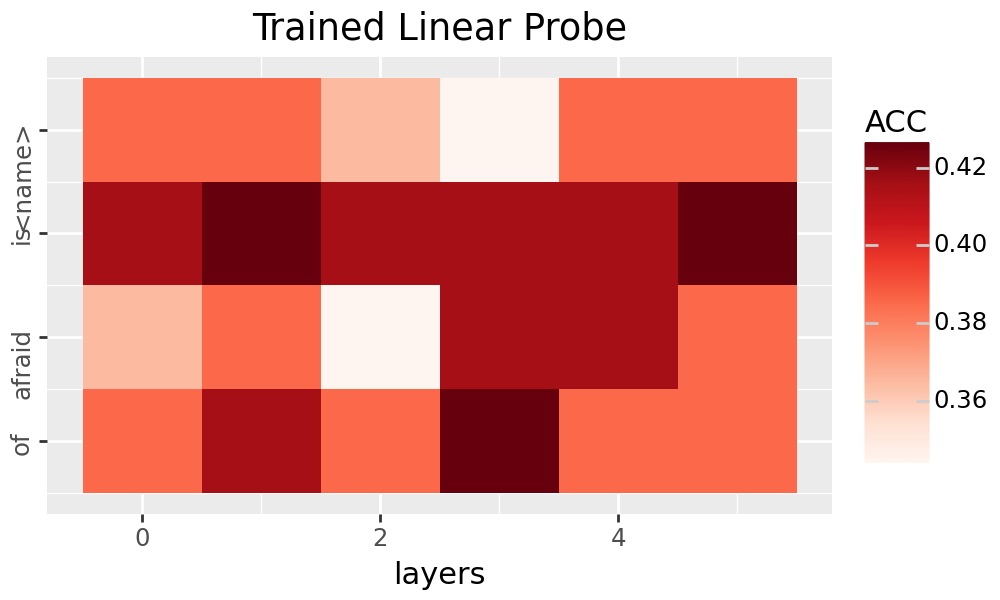

In [117]:
df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_probe.csv")
df["layer"] = df["layer"].astype(int)
df["pos"] = df["position"].astype(int)
df["ACC"] = df["acc"].astype(float)

custom_labels = ["<name>", "is", "afraid", "of", "<animal>"]
breaks = [0, 1, 2, 3, 4]

plot = (
    ggplot(df, aes(x="layer", y="pos", fill="ACC"))
    + geom_tile()
    + scale_fill_cmap("Reds") + xlab("layers")
    + scale_y_reverse(
        limits = (-0.5, 3.5),
        breaks=breaks, labels=custom_labels)
    + theme(figure_size=(5, 3)) + ylab("")
    + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    + ggtitle("Trained Linear Probe")
)
ggsave(
    plot, filename=f"/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_probe.pdf", dpi=200
)
display(plot)

In [118]:
import pandas as pd

# Import data from a CSV file
df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_probe.csv")

# Convert data types to ensure proper numerical and categorical handling
df["layer"] = df["layer"].astype(int)  # Convert 'layer' to integer
df["pos"] = df["position"].astype(int)  # Convert 'position' to integer
df["ACC"] = df["acc"].astype(float)  # Convert 'acc' to float for accurate calculations

# Transform data into a pivot table with accuracy (ACC) values for each layer and position
table = df.pivot(index="pos", columns="layer", values="ACC")

# Define custom labels for positions
custom_labels = ["<name>", "is", "afraid", "of", "<animal>"]

# Check the number of rows in the pivot table and adjust labels if necessary
if len(table.index) != len(custom_labels):
    custom_labels = custom_labels[:len(table.index)]  # Trim labels if there are fewer rows

# Replace the positional indices with custom labels for better interpretability
table.index = custom_labels

# Display the table in Colab
from IPython.display import display
display(table)

# Optionally, save the table to a CSV file for further analysis
table.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP-2024/lista4/tutorial_data/pyvene_gender_probe_table.csv")


layer,0,1,2,3,4,5
<name>,0.385417,0.385417,0.364583,0.343750,0.385417,0.385417
is,0.416667,0.427083,0.416667,0.416667,0.416667,0.427083
afraid,0.364583,0.385417,0.343750,0.416667,0.416667,0.385417
of,0.385417,0.416667,0.385417,0.427083,0.385417,0.385417
